In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(12, 10)})

In [134]:
import warnings
warnings.filterwarnings("ignore")

### Insert dataframes

In [3]:
import os

In [4]:
cwd = os.getcwd()

In [116]:
crypto_norm = pd.read_pickle(cwd + '/data/crypto_norm.pkl')
crypto_daily = pd.read_pickle(cwd + '/data/crypto_daily.pkl')
crypto_weekly = pd.read_pickle(cwd + '/data/crypto_weekly.pkl')
crypto_monthly = pd.read_pickle(cwd + '/data/monthly_count.pkl')
full_df_no_duplicates = pd.read_pickle(cwd + '/data/full_df_no_duplicates.pkl')
grouped_df = pd.read_pickle(cwd + '/data/grouped_df.pkl')

### Anomaly Detection

#### VAR

In [117]:
from statsmodels.tsa.api import VAR

In [118]:
def find_best_lag(data):
    max_lag = 30
    var_model = VAR(data)
    # select the best lag order
    lag_results = var_model.select_order(max_lag)
    selected_lag = lag_results.aic
    print("Best lag order:", selected_lag)
    return selected_lag

In [119]:
def find_anomalies_var(data,selected_lag):
    var = VAR(data)
    var_fitresults = var.fit(selected_lag)
    squared_errors = var_fitresults.resid.sum(axis=1) ** 2
    
    threshold = np.mean(squared_errors) + 2.5*np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

#### Isolation Forest

The Isolation forest in skearn has 4 important inputs:


- n_estimators: Number of Isolation trees trained.
- max_samples: Number of data points used to train each tree.
- contamination: Fraction of anomalous data points. For example, if we suspect 5% of the data to be anomalous, we set contamination to 0.05
- max_features: Number of features to be used to train each tree(This is in contrast to Random Forests where we decide on a random subset of features for each split).


It has 2 Important methods:


- decision_function(X): Returns a score — such that examples having more negative scores are more anomalous.
- predict(X): Returns -1 for Anomalous points and +1 for normal points. The number of points output as anomalous depends on the contamination value set while fitting the model.

In [120]:
from sklearn import ensemble

In [121]:
def find_anomalies_isl(data,n_estimators,max_samples,contamination,max_features):
    isl_model = ensemble.IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination, 
                max_features=max_features, bootstrap=False, n_jobs=1, random_state=1, verbose=0, warm_start=False).fit(data)

    anomaly_score = isl_model.decision_function(data)
    predictions = isl_model.predict(data)
    return anomaly_score,predictions

In [122]:
def find_margins(scores):
    median = np.median(scores)
    upper_quartile = np.percentile(scores, 75)
    lower_quartile = np.percentile(scores, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = scores[scores<=upper_quartile+1.5*iqr].max()
    lower_whisker = scores[scores>=lower_quartile-1.5*iqr].min()
    return upper_whisker,lower_whisker

#### One Class — Support Vector Machine(OC-SVM)

In [123]:
from sklearn import svm

In [124]:
####### Fit One Class - SVM #############
def find_anomalies_ocsvm(data,kernel):
    svm_model = svm.OneClassSVM(kernel=kernel, gamma="scale", nu=0.01).fit(data)
    anomaly_scores = svm_model.decision_function(data)
    predictions = svm_model.predict(data)
    return predictions,anomaly_scores

#### Cryprocurrencies

In [13]:
crypto_weekly

date cryptocurrency_name              repo_name  commits_7d  \
1        2018-01-21                  0x                  0x.js        70.0   
2        2018-01-21                  0x  0x.js-starter-project         0.0   
10       2018-01-21                  0x           bignumber.js         0.0   
11       2018-01-21                  0x               branding         0.0   
12       2018-01-21                  0x         chai-bignumber         0.0   
...             ...                 ...                    ...         ...   
3013774  2019-02-04             ZenCash             zen-seeder         0.0   
3013776  2019-02-04             ZenCash      zen-tipbot-docker         0.0   
3013777  2019-02-04             ZenCash             zen-tipbot         0.0   
3013778  2019-02-04             ZenCash                 znodes         0.0   
3013779  2019-02-04             ZenCash                 z-nomp         0.0   

         changes_7d_loc_added  changes_7d_loc_removed  forks  watchers  
1                      1416.0                   513.0   58.0      62.0  
2                         0.0                     0.0    0.0       4.0  
10                        0.0                     0.0    0.0       4.0  
11                        0.0                     0.0    0.0       5.0  
12                        0.0                     0.0    0.0       5.0  
...                       ...                     ...    ...       ...  
3013774                   0.0                     0.0    0.0       6.0  
3013776                   0.0                     0.0    0.0       9.0  
3013777                   0.0                     0.0    6.0      11.0  
3013778                   0.0                     0.0    1.0       2.0  
3013779                   0.0                     0.0    1.0      11.0  

[1820721 rows x 8 columns]

In [14]:
weekly_grouped = crypto_weekly.groupby('date').sum()[['commits_7d','changes_7d_loc_added','changes_7d_loc_removed']]

In [15]:
weekly_grouped

commits_7d  changes_7d_loc_added  changes_7d_loc_removed
date                                                                
2018-01-21      4742.0             2166469.0                875858.0
2018-01-22      5312.0             3285042.0               2273592.0
2018-01-23      5409.0             3230168.0               2311795.0
2018-01-24      5700.0             4479924.0               2495540.0
2018-01-25      5884.0             4170486.0               2443281.0
...                ...                   ...                     ...
2019-01-31      7338.0             9966623.0               4414469.0
2019-02-01      7353.0             7057969.0               4357118.0
2019-02-02      7277.0             5786647.0               4441513.0
2019-02-03      7317.0             6855484.0               4496010.0
2019-02-04      7400.0             6638035.0               4454187.0

[339 rows x 3 columns]

VAR

In [21]:
selected_lag_crypto = find_best_lag(weekly_grouped)

Best lag order: 6


In [22]:
predictions_var_crypto,threshold_var_crypto = find_anomalies_var(weekly_grouped,selected_lag_crypto)

In [23]:
crypto_var = weekly_grouped.iloc[selected_lag_crypto:, :]
crypto_var['Predictions_VAR'] = predictions_var_crypto.values
crypto_var[crypto_var['Predictions_VAR'] == 1]

commits_7d  changes_7d_loc_added  changes_7d_loc_removed  \
date                                                                   
2018-03-16      7879.0            18147444.0              10653559.0   
2018-05-17      8144.0            15369850.0               8883918.0   
2018-05-19       925.0              229666.0                107392.0   
2018-06-02      8650.0            16103679.0               3837872.0   
2018-06-30      7690.0            27628218.0               5341585.0   

            Predictions_VAR  
date                         
2018-03-16                1  
2018-05-17                1  
2018-05-19                1  
2018-06-02                1  
2018-06-30                1

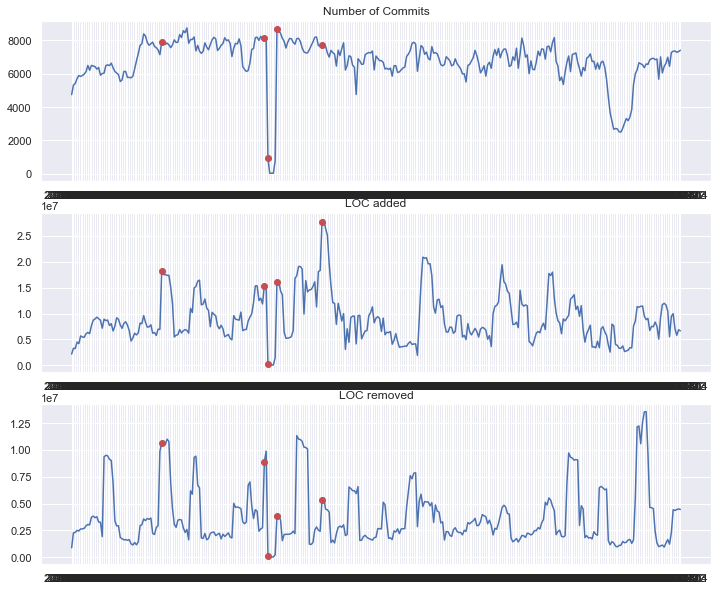

In [24]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(weekly_grouped['commits_7d'])
ax[0].plot(crypto_var[crypto_var.Predictions_VAR==1].index, crypto_var[crypto_var.Predictions_VAR==1].commits_7d, 'ro')
ax[1].set_title("LOC added")
ax[1].plot(weekly_grouped['changes_7d_loc_added'])
ax[1].plot(crypto_var[crypto_var.Predictions_VAR==1].index, crypto_var[crypto_var.Predictions_VAR==1].changes_7d_loc_added, 'ro')
ax[2].set_title("LOC removed")
ax[2].plot(weekly_grouped['changes_7d_loc_removed'])
ax[2].plot(crypto_var[crypto_var.Predictions_VAR==1].index, crypto_var[crypto_var.Predictions_VAR==1].changes_7d_loc_removed, 'ro')


Isolation Forest

Two possible ways of detecting the anomalies/outliers:


- Using the prediction labels of the model (this is strongly affected by the contamination level we set during training)
- Getting the anomaly_score produced by the decision_function and then perform univariate anomaly detection there.

In [25]:
isl_anomaly_score_crypto, isl_predictions_crypto = find_anomalies_isl(weekly_grouped,n_estimators = 100,max_samples = 300,
                               contamination = 0.01,max_features = 3)

First Way

In [26]:
crypto_isl = weekly_grouped
crypto_isl['predictions_isl'] = isl_predictions_crypto
crypto_isl[crypto_isl['predictions_isl'] == -1]

commits_7d  changes_7d_loc_added  changes_7d_loc_removed  \
date                                                                   
2018-05-19       925.0              229666.0                107392.0   
2018-05-21        30.0               15146.0                 15277.0   
2018-05-23        35.0               61463.0                 22326.0   
2018-06-01       764.0             1460691.0                228333.0   

            predictions_isl  
date                         
2018-05-19               -1  
2018-05-21               -1  
2018-05-23               -1  
2018-06-01               -1

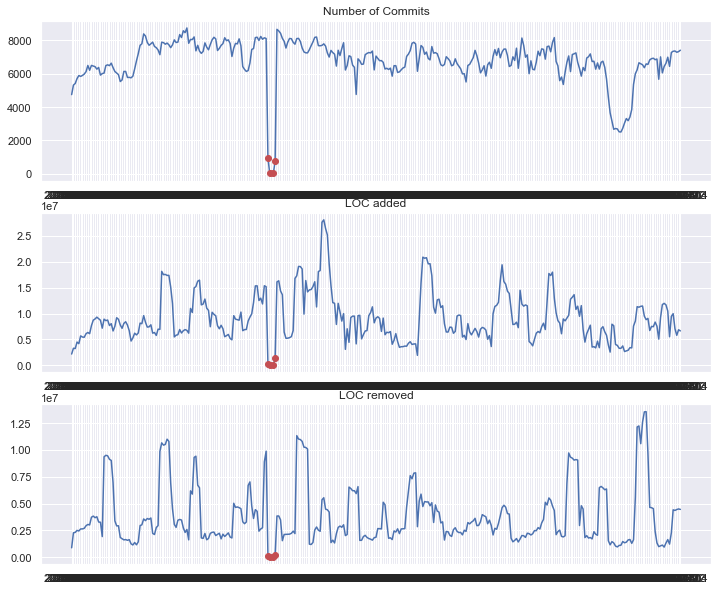

In [27]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(weekly_grouped['commits_7d'])
ax[0].plot(crypto_isl[crypto_isl.predictions_isl==-1].index, crypto_isl[crypto_isl.predictions_isl==-1].commits_7d, 'ro')
ax[1].set_title("LOC added")
ax[1].plot(weekly_grouped['changes_7d_loc_added'])
ax[1].plot(crypto_isl[crypto_isl.predictions_isl==-1].index, crypto_isl[crypto_isl.predictions_isl==-1].changes_7d_loc_added, 'ro')
ax[2].set_title("LOC removed")
ax[2].plot(weekly_grouped['changes_7d_loc_removed'])
ax[2].plot(crypto_isl[crypto_isl.predictions_isl==-1].index, crypto_isl[crypto_isl.predictions_isl==-1].changes_7d_loc_removed, 'ro')

Second Way

This way is just a statistical way by using the IQR and the upper/lower quartiles of the anomaly scores to determine which dates fall out of these ranges.


The point is that the anomaly scores are essentialy another time series. In that time series we can then implement another algorithm and get the anomalies. With that way maybe we can combine the benefits of two methods instead of one.

<AxesSubplot:>

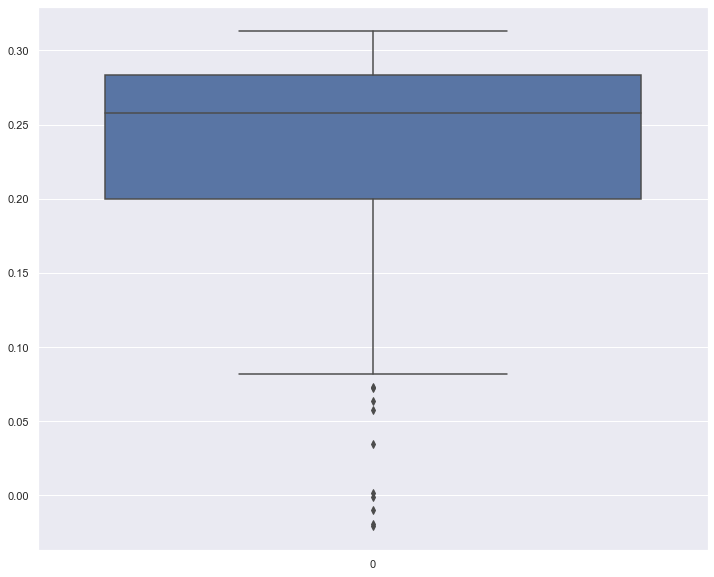

In [28]:
sns.boxplot(data = isl_anomaly_score_crypto)

As we can see here 10 data points are outside of the IQR range defined by the boxplot. (Previously 4 data points were detected as outliers)

In [29]:
upper_whisker, lower_whisker = find_margins(isl_anomaly_score_crypto)
crypto_isl['anomaly_score_isl'] = isl_anomaly_score_crypto
crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker]

commits_7d  changes_7d_loc_added  changes_7d_loc_removed  \
date                                                                   
2018-05-19       925.0              229666.0                107392.0   
2018-05-21        30.0               15146.0                 15277.0   
2018-05-22        36.0               22807.0                 21613.0   
2018-05-23        35.0               61463.0                 22326.0   
2018-06-01       764.0             1460691.0                228333.0   
2018-06-30      7690.0            27628218.0               5341585.0   
2018-07-02      7782.0            28105171.0               5539943.0   
2018-07-23      4752.0             4125991.0               5926598.0   
2019-01-15      6351.0             9483026.0              13540026.0   
2019-01-16      6580.0             8814942.0              13557092.0   

            predictions_isl  anomaly_score_isl  
date                                            
2018-05-19               -1          -0.019015  
2018-05-21               -1          -0.020282  
2018-05-22                1           0.001679  
2018-05-23               -1          -0.001029  
2018-06-01               -1          -0.010105  
2018-06-30                1           0.063665  
2018-07-02                1           0.034997  
2018-07-23                1           0.072174  
2019-01-15                1           0.057883  
2019-01-16                1           0.073077

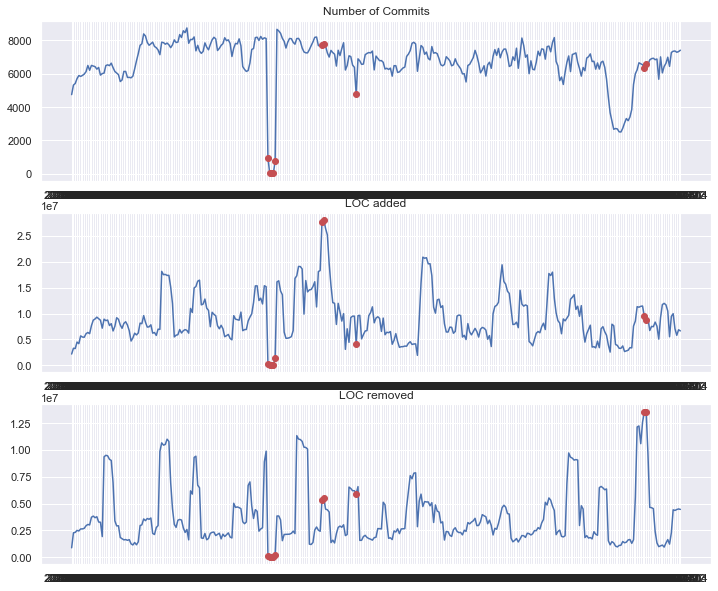

In [30]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(weekly_grouped['commits_7d'])
ax[0].plot(crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].index, 
           crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].commits_7d, 'ro')
ax[1].set_title("LOC added")
ax[1].plot(weekly_grouped['changes_7d_loc_added'])
ax[1].plot(crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].index, 
           crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].changes_7d_loc_added, 'ro')
ax[2].set_title("LOC removed")
ax[2].plot(weekly_grouped['changes_7d_loc_removed'])
ax[2].plot(crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].index, 
           crypto_isl[crypto_isl['anomaly_score_isl'] < lower_whisker].changes_7d_loc_removed, 'ro')

One Class SVM

In [31]:
predictions_svm, anomaly_scores_svm = find_anomalies_ocsvm(weekly_grouped[['commits_7d','changes_7d_loc_added','changes_7d_loc_removed']],
                                                          kernel = 'rbf')



In [32]:
crypto_ocsvm = weekly_grouped
crypto_ocsvm['predictions_svm'] = predictions_svm
crypto_ocsvm[crypto_ocsvm['predictions_svm'] == -1]

commits_7d  changes_7d_loc_added  changes_7d_loc_removed  \
date                                                                   
2018-05-21        30.0               15146.0                 15277.0   
2018-06-16      8108.0            19098153.0              11006620.0   
2019-01-16      6580.0             8814942.0              13557092.0   
2019-01-26      6427.0            11961267.0                940554.0   

            predictions_isl  anomaly_score_isl  predictions_svm  
date                                                             
2018-05-21               -1          -0.020282               -1  
2018-06-16                1           0.081977               -1  
2019-01-16                1           0.073077               -1  
2019-01-26                1           0.191644               -1

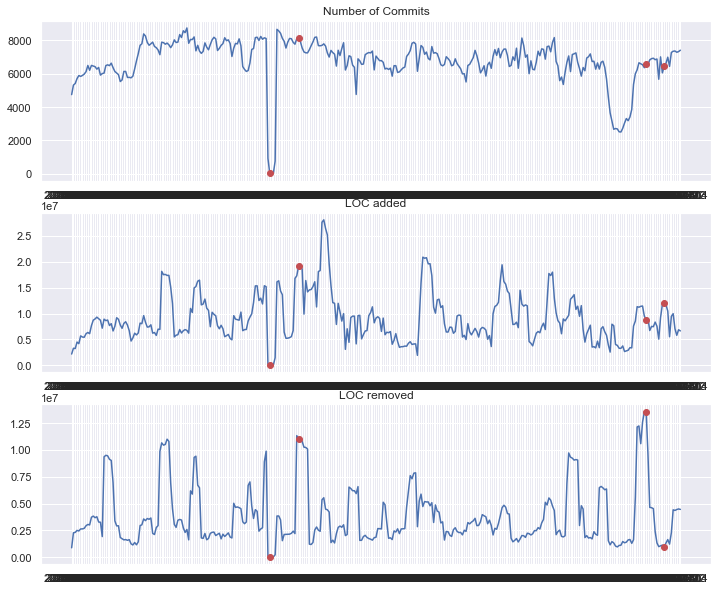

In [33]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(weekly_grouped['commits_7d'])
ax[0].plot(crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].index, crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].commits_7d, 'ro')
ax[1].set_title("LOC added")
ax[1].plot(weekly_grouped['changes_7d_loc_added'])
ax[1].plot(crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].index, crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].changes_7d_loc_added, 'ro')
ax[2].set_title("LOC removed")
ax[2].plot(weekly_grouped['changes_7d_loc_removed'])
ax[2].plot(crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].index, crypto_ocsvm[crypto_ocsvm.predictions_svm==-1].changes_7d_loc_removed, 'ro')


### Softwares

In [125]:
full_df_no_duplicates

hash_id        date  lines_added  \
0     000899acba05e5b9a2a630d59164ba055553e278  2017-06-24            1   
1     0016185419e35dc903d0098689cb00326500f054  2021-12-26           25   
2     001aaada7dab82c3c09cde5f8e14245dc9d8b454  2021-11-29           84   
3     001bd2f7ae2997652bf3ac8e76a2a545fae9924f  2014-09-14           12   
4     00255f2d013ad688c9fceade16fe478da572005d  2013-12-10            2   
...                                        ...         ...          ...   
8739  ffca20367627ab5ee2d597d1194e0f33efbe303d  2015-09-11            3   
8740  ffcdaadcccb3dfd61fae2661c5c72b842370f6ce  2019-07-29           17   
8741  ffd2e9a8f173a691bf329819cdc2a74751a5b15b  2015-11-02            3   
8742  ffedf33f170c8f0f8cc9bd943c2175ac73bf5d77  2016-04-20          124   
8743  fffd5ea3f5a3389f97408370fe286d5ecc697688  2020-04-28           23   

      lines_deleted           project                               Packages  
0                 1             log4j                    [log4j-api-message]  
1                 1  jackson-databind                                [deser]  
2                54             log4j  [log4j-core-util, log4j-core-pattern]  
3                 8             log4j                      [log4j-core-util]  
4                 1  jackson-databind                                  [ser]  
...             ...               ...                                    ...  
8739              3             log4j                    [log4j-core-config]  
8740              4  jackson-databind                                 [type]  
8741              1             log4j                    [log4j-core-filter]  
8742              1             log4j                    [log4j-core-layout]  
8743             11  jackson-databind                                [deser]  

[8744 rows x 6 columns]

In [126]:
grouped_df

commits_24h  changes_24h_lines_added  changes_24h_lines_removed  \
date                                                                          
2010-01-03            3                      921                          3   
2010-01-09            4                       16                         14   
2010-01-16            2                        9                         10   
2010-01-21            1                        9                          9   
2010-01-25            3                       12                         17   
...                 ...                      ...                        ...   
2022-04-19            4                       26                         43   
2022-04-20            7                      252                         30   
2022-04-21            2                       11                         20   
2022-04-25            1                        2                          2   
2022-04-27            2                       43                         16   

            commits_7d  changes_7d_lines_added  changes_7d_lines_removed  
date                                                                      
2010-01-03           3                     921                         3  
2010-01-09           7                     937                        17  
2010-01-16           2                       9                        10  
2010-01-21           3                      18                        19  
2010-01-25           4                      21                        26  
...                ...                     ...                       ...  
2022-04-19           7                    1115                       339  
2022-04-20          13                     755                       123  
2022-04-21          15                     766                       143  
2022-04-25          14                     291                        95  
2022-04-27           5                      56                        38  

[2371 rows x 6 columns]

In [127]:
#Year range in the dataset
years = int((grouped_df.index.max() - grouped_df.index.min()).days / 365.2425)
print("Years in grouped_df:", years)
#We want to have the last 2 years
print("Last date of the dataset:",grouped_df.index.max())

Years in grouped_df: 12
Last date of the dataset: 2022-04-27


In [128]:
grouped_df_short = grouped_df.loc[pd.to_datetime('2020-04-27'):]

VAR

In [135]:
selected_lag_software = find_best_lag(grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']])


Best lag order: 6


In [136]:
predictions_var_software,threshold_var_software = find_anomalies_var(grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']],
                                                                     selected_lag_software)

In [137]:
software_var = grouped_df_short.iloc[selected_lag_software:, :]
software_var['Predictions_VAR'] = predictions_var_software.values
software_var[software_var['Predictions_VAR'] == 1]

commits_24h  changes_24h_lines_added  changes_24h_lines_removed  \
date                                                                          
2020-06-17            8                     5319                       1791   
2020-08-19            2                    18333                        289   
2020-08-26            1                       91                         43   
2020-08-31            1                        2                          2   

            commits_7d  changes_7d_lines_added  changes_7d_lines_removed  \
date                                                                       
2020-06-17          44                    7336                      3183   
2020-08-19          11                   18946                       637   
2020-08-26          13                    1361                       469   
2020-08-31           9                    1478                       775   

            Predictions_VAR  
date                         
2020-06-17                1  
2020-08-19                1  
2020-08-26                1  
2020-08-31                1

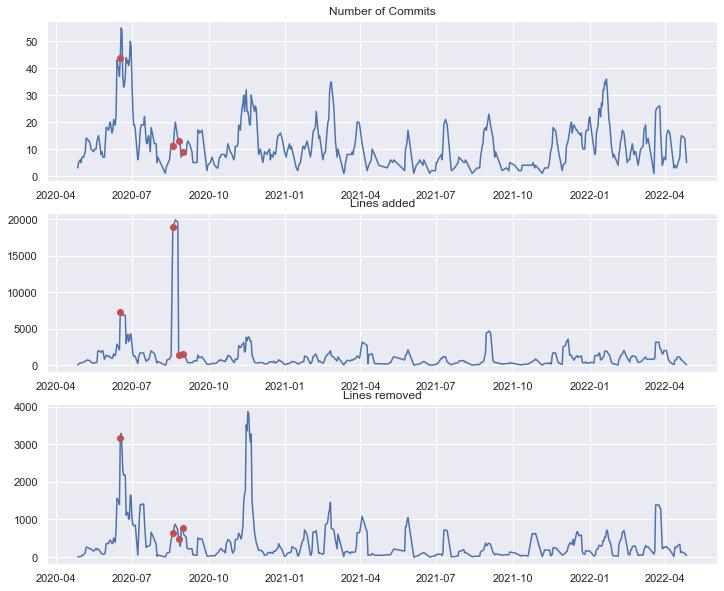

In [138]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_var[software_var.Predictions_VAR==1].index, software_var[software_var.Predictions_VAR==1].commits_7d, 'ro')
ax[1].set_title("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_var[software_var.Predictions_VAR==1].index, software_var[software_var.Predictions_VAR==1].changes_7d_lines_added, 'ro')
ax[2].set_title("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_var[software_var.Predictions_VAR==1].index, software_var[software_var.Predictions_VAR==1].changes_7d_lines_removed, 'ro')


Isolation Forest

Two possible ways of detecting the anomalies/outliers:


- Using the prediction labels of the model (this is strongly affected by the contamination level we set during training)
- Getting the anomaly_score produced by the decision_function and then perform univariate anomaly detection there.

In [139]:
isl_anomaly_score_sftw, isl_predictions_sftw = find_anomalies_isl(grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']],
                                                n_estimators = 100,max_samples = 300,contamination = 0.01,max_features = 3)


First Way

In [140]:
software_isl = grouped_df_short
software_isl['predictions_ISL'] = isl_predictions_sftw
software_isl[software_isl['predictions_ISL'] == -1]

commits_24h  changes_24h_lines_added  changes_24h_lines_removed  \
date                                                                          
2020-06-17            8                     5319                       1791   
2020-06-18           13                      267                        118   
2020-06-19            6                      160                         43   
2020-08-19            2                    18333                        289   
2020-08-22            5                      484                         32   

            commits_7d  changes_7d_lines_added  changes_7d_lines_removed  \
date                                                                       
2020-06-17          44                    7336                      3183   
2020-06-18          55                    7559                      3293   
2020-06-19          54                    6829                      2926   
2020-08-19          11                   18946                       637   
2020-08-22          20                   19937                       869   

            predictions_ISL  
date                         
2020-06-17               -1  
2020-06-18               -1  
2020-06-19               -1  
2020-08-19               -1  
2020-08-22               -1

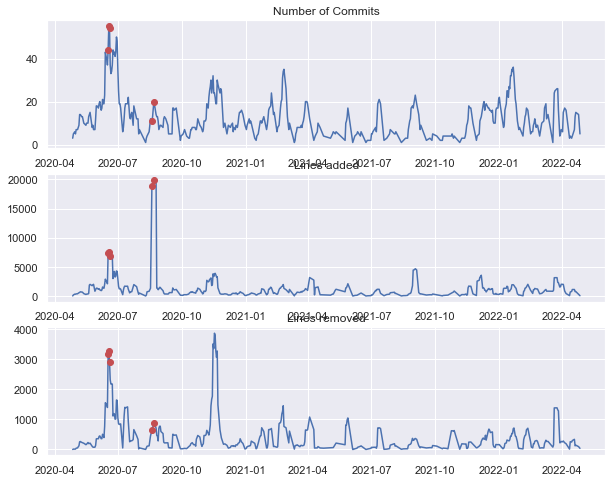

In [141]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(10, 8))
ax[0].set_title("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_isl[software_isl.predictions_ISL==-1].index, software_isl[software_isl.predictions_ISL==-1].commits_7d, 'ro')
ax[1].set_title("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_isl[software_isl.predictions_ISL==-1].index, software_isl[software_isl.predictions_ISL==-1].changes_7d_lines_added, 'ro')
ax[2].set_title("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_isl[software_isl.predictions_ISL==-1].index, software_isl[software_isl.predictions_ISL==-1].changes_7d_lines_removed, 'ro')


Second Way

This way is just a statistical way by using the IQR and the upper/lower quartiles of the anomaly scores to determine which dates fall out of these ranges.


The point is that the anomaly scores are essentialy another time series. In that time series we can then implement another algorithm and get the anomalies. With that way maybe we can combine the benefits of two methods instead of one.

<AxesSubplot:>

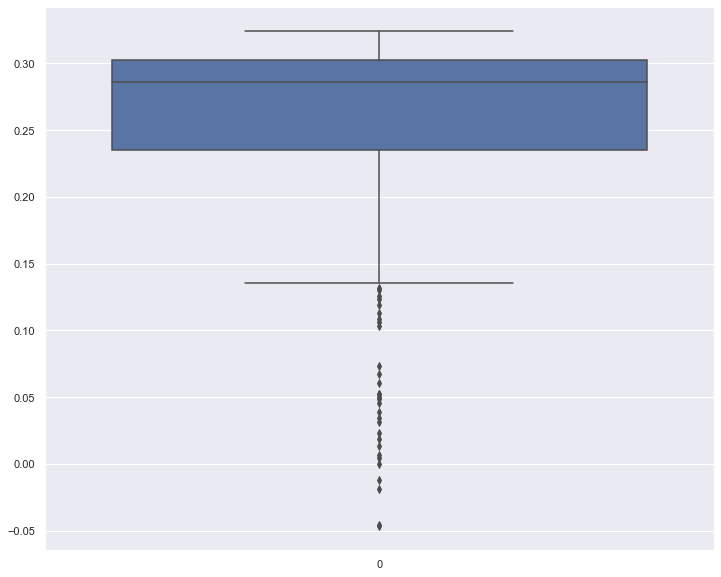

In [144]:
sns.boxplot(data = isl_anomaly_score_sftw)

As we can see here **many** data points are outside of the IQR range defined by the boxplot. (Previously 4 data points were detected as outliers)

In [145]:
upper_whisker, lower_whisker = find_margins(isl_anomaly_score_sftw)
software_isl['anomaly_score_isl'] = isl_anomaly_score_sftw
software_isl[software_isl['anomaly_score_isl'] < lower_whisker][['commits_7d','changes_7d_lines_added','changes_7d_lines_removed','predictions_ISL','anomaly_score_isl']]


commits_7d  changes_7d_lines_added  changes_7d_lines_removed  \
date                                                                       
2020-06-13          43                    2890                      1557   
2020-06-14          41                    2603                      1521   
2020-06-17          44                    7336                      3183   
2020-06-18          55                    7559                      3293   
2020-06-19          54                    6829                      2926   
2020-06-20          37                    6922                      2321   
2020-06-21          33                    6843                      2180   
2020-06-22          34                    6841                      2186   
2020-06-23          37                    6842                      2177   
2020-06-24          44                    2991                      1114   
2020-06-25          42                    3891                      1195   
2020-06-26          43                    4208                      1185   
2020-06-27          41                    3250                      1008   
2020-06-28          43                    3405                      1018   
2020-06-29          50                    4298                      1649   
2020-06-30          48                    4202                      1634   
2020-08-19          11                   18946                       637   
2020-08-20          13                   19196                       677   
2020-08-21          17                   19551                       852   
2020-08-22          20                   19937                       869   
2020-08-25          14                   19603                       715   
2020-11-14          28                    1924                      1772   
2020-11-15          32                    3802                      3517   
2020-11-16          24                    3349                      3361   
2020-11-17          24                    3791                      3872   
2020-11-18          22                    3891                      3810   
2020-11-19          19                    3622                      3282   
2020-11-20          19                    3273                      3068   
2020-11-21          30                    3320                      3279   
2021-04-09           2                    2725                       664   

            predictions_ISL  anomaly_score_isl  
date                                            
2020-06-13                1           0.119245  
2020-06-14                1           0.131627  
2020-06-17               -1          -0.018608  
2020-06-18               -1          -0.045805  
2020-06-19               -1          -0.046292  
2020-06-20                1           0.031611  
2020-06-21                1           0.045908  
2020-06-22                1           0.048551  
2020-06-23                1           0.052303  
2020-06-24                1           0.108311  
2020-06-25                1           0.112695  
2020-06-26                1           0.106279  
2020-06-27                1           0.130161  
2020-06-28                1           0.123594  
2020-06-29                1           0.034143  
2020-06-30                1           0.052648  
2020-08-19               -1          -0.000277  
2020-08-20                1           0.013549  
2020-08-21                1           0.004347  
2020-08-22               -1          -0.012163  
2020-08-25                1           0.006855  
2020-11-14                1           0.125829  
2020-11-15                1           0.039165  
2020-11-16                1           0.073289  
2020-11-17                1           0.023425  
2020-11-18                1           0.018547  
2020-11-19                1           0.060339  
2020-11-20                1           0.049823  
2020-11-21                1           0.067145  
2021-04-09                1           0.103024

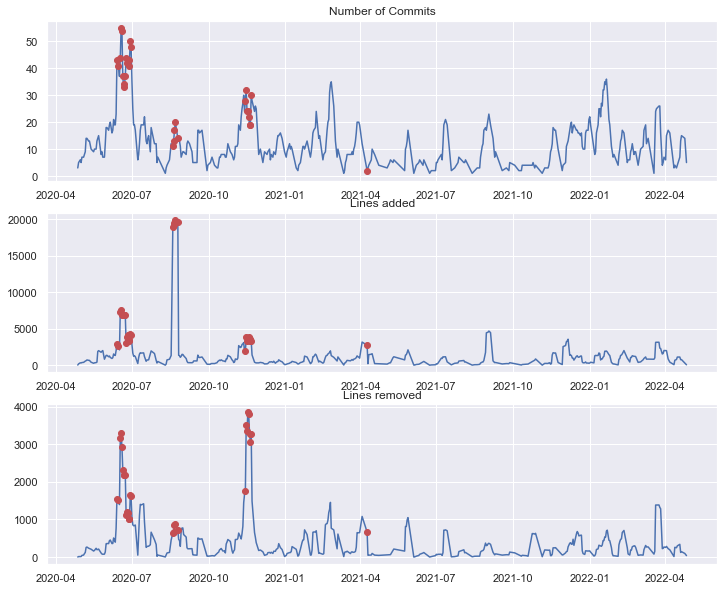

In [146]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_isl[software_isl['anomaly_score_isl'] < lower_whisker].index, 
           software_isl[software_isl['anomaly_score_isl'] < lower_whisker].commits_7d, 'ro')
ax[1].set_title("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_isl[software_isl['anomaly_score_isl'] < lower_whisker].index, 
           software_isl[software_isl['anomaly_score_isl'] < lower_whisker].changes_7d_lines_added, 'ro')
ax[2].set_title("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_isl[software_isl['anomaly_score_isl'] < lower_whisker].index, 
           software_isl[software_isl['anomaly_score_isl'] < lower_whisker].changes_7d_lines_removed, 'ro')

One Class SVM

In [147]:
predictions_svm_sftw, anomaly_scores_svm_sftw = find_anomalies_ocsvm(grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']],
                                                          kernel = 'rbf')



In [148]:
software_ocsvm = grouped_df_short[['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']]
software_ocsvm['predictions_SVM'] = predictions_svm_sftw
software_ocsvm[software_ocsvm['predictions_SVM'] == -1]

commits_7d  changes_7d_lines_added  changes_7d_lines_removed  \
date                                                                       
2020-06-18          55                    7559                      3293   
2020-11-14          28                    1924                      1772   
2020-11-17          24                    3791                      3872   
2020-11-22          28                    1404                      1490   
2021-11-30           4                    2547                        59   

            predictions_SVM  
date                         
2020-06-18               -1  
2020-11-14               -1  
2020-11-17               -1  
2020-11-22               -1  
2021-11-30               -1

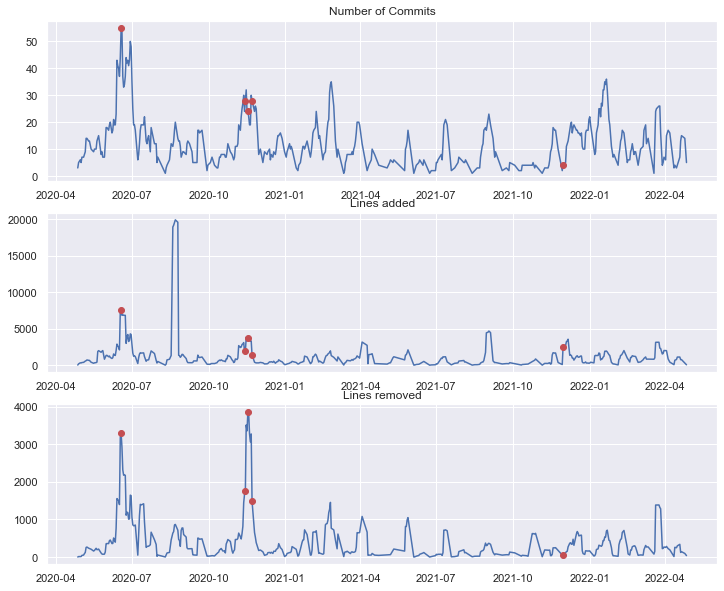

In [149]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(software_ocsvm[software_ocsvm.predictions_SVM==-1].index, software_ocsvm[software_ocsvm.predictions_SVM==-1].commits_7d, 'ro')
ax[1].set_title("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(software_ocsvm[software_ocsvm.predictions_SVM==-1].index, software_ocsvm[software_ocsvm.predictions_SVM==-1].changes_7d_lines_added, 'ro')
ax[2].set_title("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(software_ocsvm[software_ocsvm.predictions_SVM==-1].index, software_ocsvm[software_ocsvm.predictions_SVM==-1].changes_7d_lines_removed, 'ro')


### Clustering Approach

Cryptocurrencies

In [152]:
from sklearn.preprocessing import StandardScaler

In [64]:
ss = StandardScaler()
crypto_scaled = pd.DataFrame(ss.fit_transform(weekly_grouped[['commits_7d', 'changes_7d_loc_added','changes_7d_loc_removed']]), 
                             columns=['commits_7d', 'changes_7d_loc_added','changes_7d_loc_removed'])


<IPython.core.display.Javascript object>


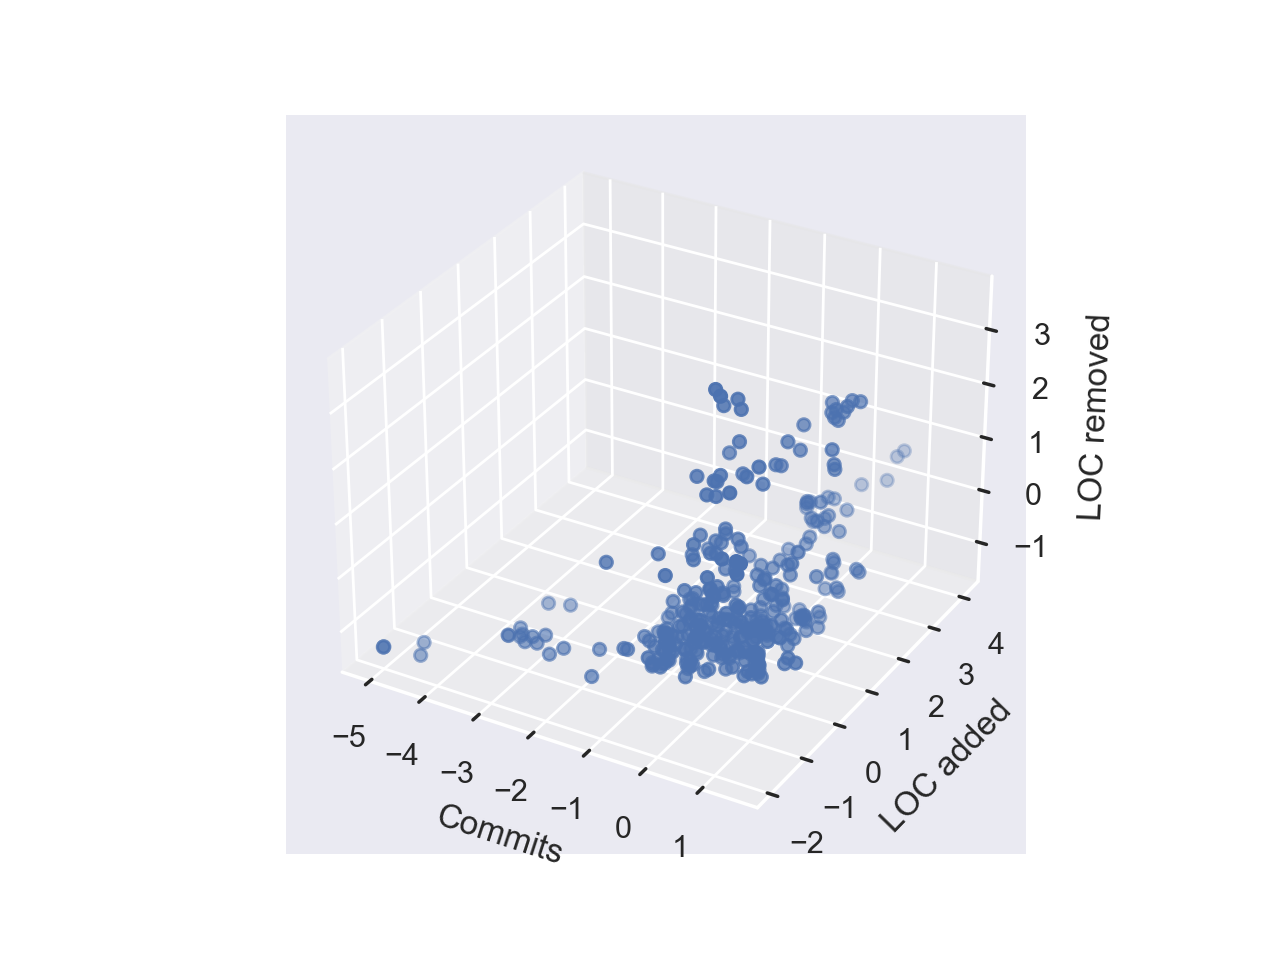

In [72]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(crypto_scaled.commits_7d, crypto_scaled.changes_7d_loc_added, crypto_scaled.changes_7d_loc_removed)
ax.set_xlabel('Commits')
ax.set_ylabel('LOC added')
ax.set_zlabel('LOC removed')
plt.show()

In [153]:
from sklearn.cluster import KMeans

In [67]:
km = KMeans(n_clusters=2)
model = km.fit(crypto_scaled)

<IPython.core.display.Javascript object>


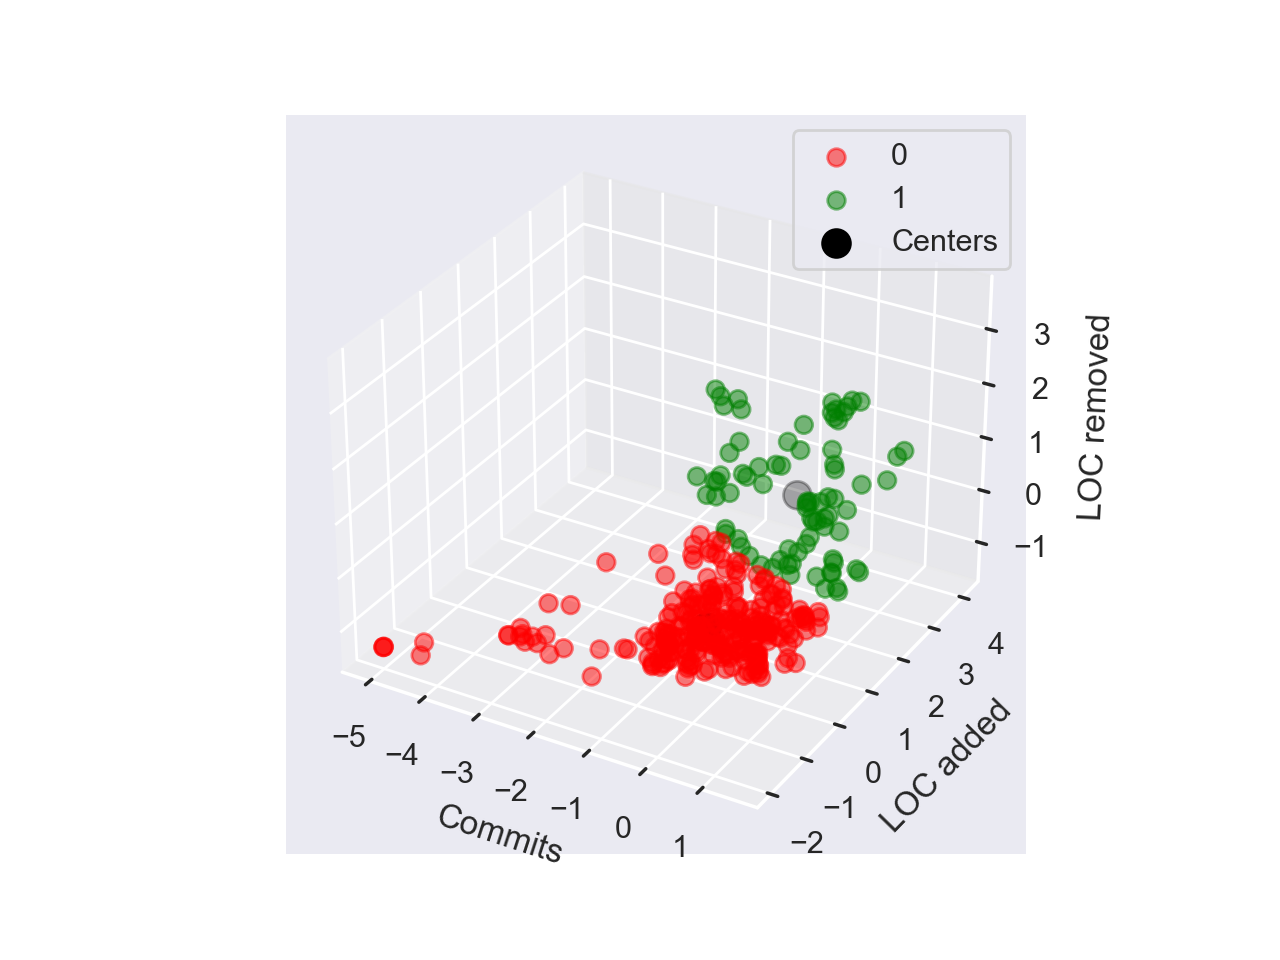

In [73]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','green']
for i in range(np.max(model.labels_)+1):
    ax.scatter(crypto_scaled[model.labels_==i].commits_7d, crypto_scaled[model.labels_==i].changes_7d_loc_added, 
               crypto_scaled[model.labels_==i].changes_7d_loc_removed, label=i, c=colors[i], alpha=0.5, s=40)
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2],
           label='Centers', c="black", s=100) 
ax.set_xlabel('Commits')
ax.set_ylabel('LOC added')
ax.set_zlabel('LOC removed')
plt.legend()

In [69]:
def distance_from_center(commits, added, removed, label):
    '''
    Calculate the Euclidean distance between a data point and the center of its cluster.
    :return: The resulting Euclidean distance  
    '''
    center_commits =  model.cluster_centers_[label,0]
    center_lines_added =  model.cluster_centers_[label,1]
    center_lines_removed =  model.cluster_centers_[label,2]
    distance = np.sqrt((commits - center_commits) ** 2 + (added - center_lines_added) ** 2 
                       + (removed - center_lines_removed) ** 2)
    return np.round(distance, 3)
crypto_scaled['label'] = model.labels_
crypto_scaled['distance'] = distance_from_center(crypto_scaled.commits_7d, crypto_scaled.changes_7d_loc_added,
                                                 crypto_scaled.changes_7d_loc_removed,crypto_scaled.label)

In [70]:
anomalies_idx = list(crypto_scaled.sort_values('distance', ascending=False).head(10).index)
anomalies_kmeans = crypto_scaled[crypto_scaled.index.isin(anomalies_idx)]
print(anomalies_kmeans)

     commits_7d  changes_7d_loc_added  changes_7d_loc_removed  label  distance
109   -4.372463             -1.896952               -1.357995      0     4.597
110   -5.045251             -1.943042               -1.391953      0     5.243
111   -5.040741             -1.941396               -1.389617      0     5.238
112   -5.041492             -1.933090               -1.389354      0     5.236
113   -4.493490             -1.632464               -1.313412      0     4.622
302   -3.029142             -1.085036               -1.015327      0     3.038
303   -3.047183             -1.120052               -1.044153      0     3.069
304   -3.177230             -1.242818               -0.993167      0     3.213
305   -3.185499             -1.243464               -0.987124      0     3.220
306   -3.018618             -1.144273               -0.858817      0     3.014


<IPython.core.display.Javascript object>


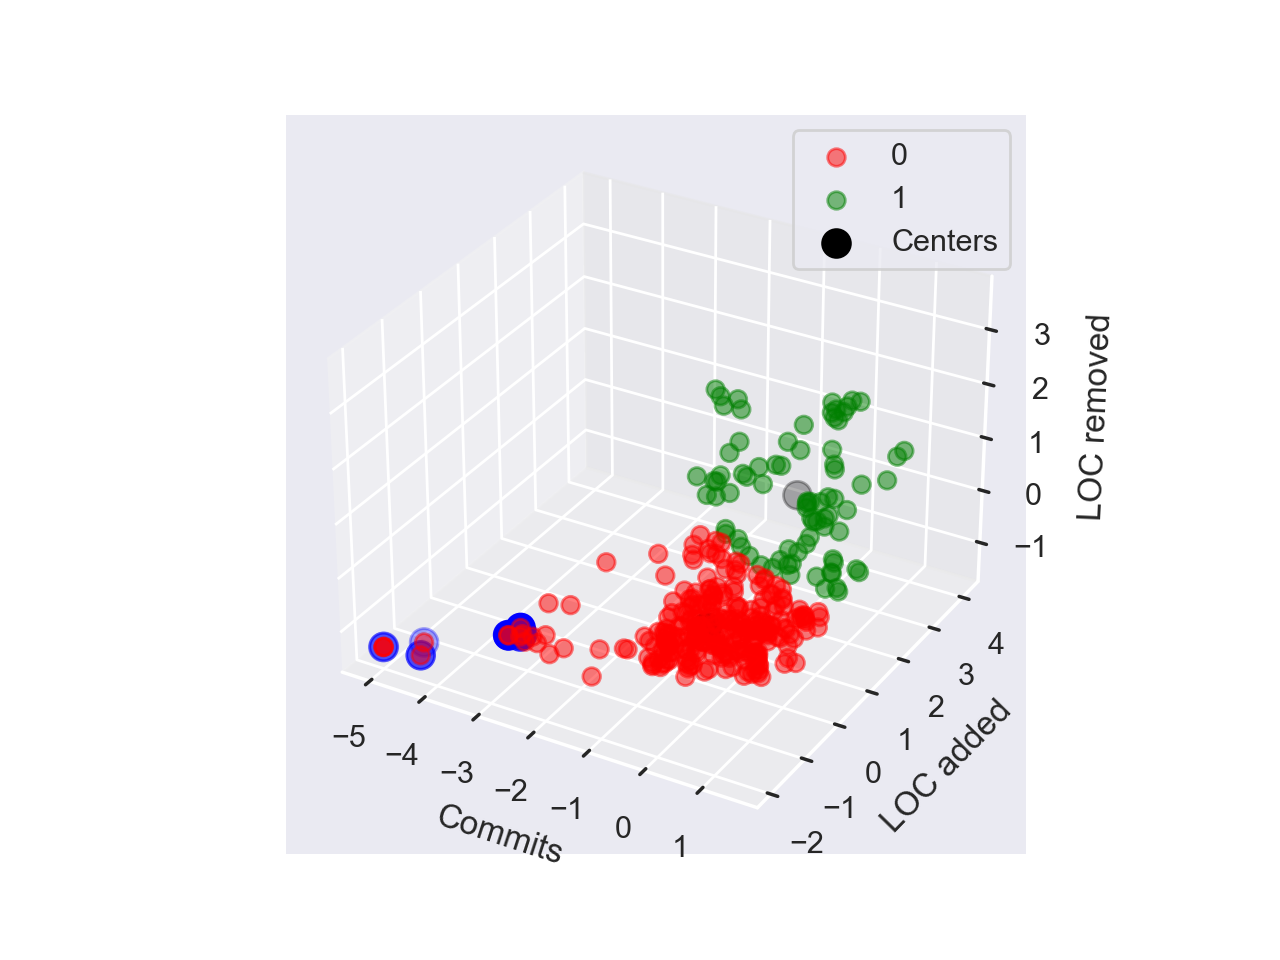

In [71]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','green']
for i in range(np.max(model.labels_)+1):
    ax.scatter(crypto_scaled[model.labels_==i].commits_7d, crypto_scaled[model.labels_==i].changes_7d_loc_added, 
               crypto_scaled[model.labels_==i].changes_7d_loc_removed, label=i, c=colors[i], alpha=0.5, s=40)
ax.scatter(anomalies_kmeans.commits_7d, anomalies_kmeans.changes_7d_loc_added, anomalies_kmeans.changes_7d_loc_removed,
           c='blue', s=100)
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2],
           label='Centers', c="black", s=100) 
ax.set_xlabel('Commits')
ax.set_ylabel('LOC added')
ax.set_zlabel('LOC removed')
plt.legend()

Software

In [154]:
ss = StandardScaler()
software_scaled = pd.DataFrame(ss.fit_transform(grouped_df_short[['commits_7d', 'changes_7d_lines_added','changes_7d_lines_removed']]), 
                             columns=['commits_7d', 'changes_7d_lines_added','changes_7d_lines_removed'])


<IPython.core.display.Javascript object>


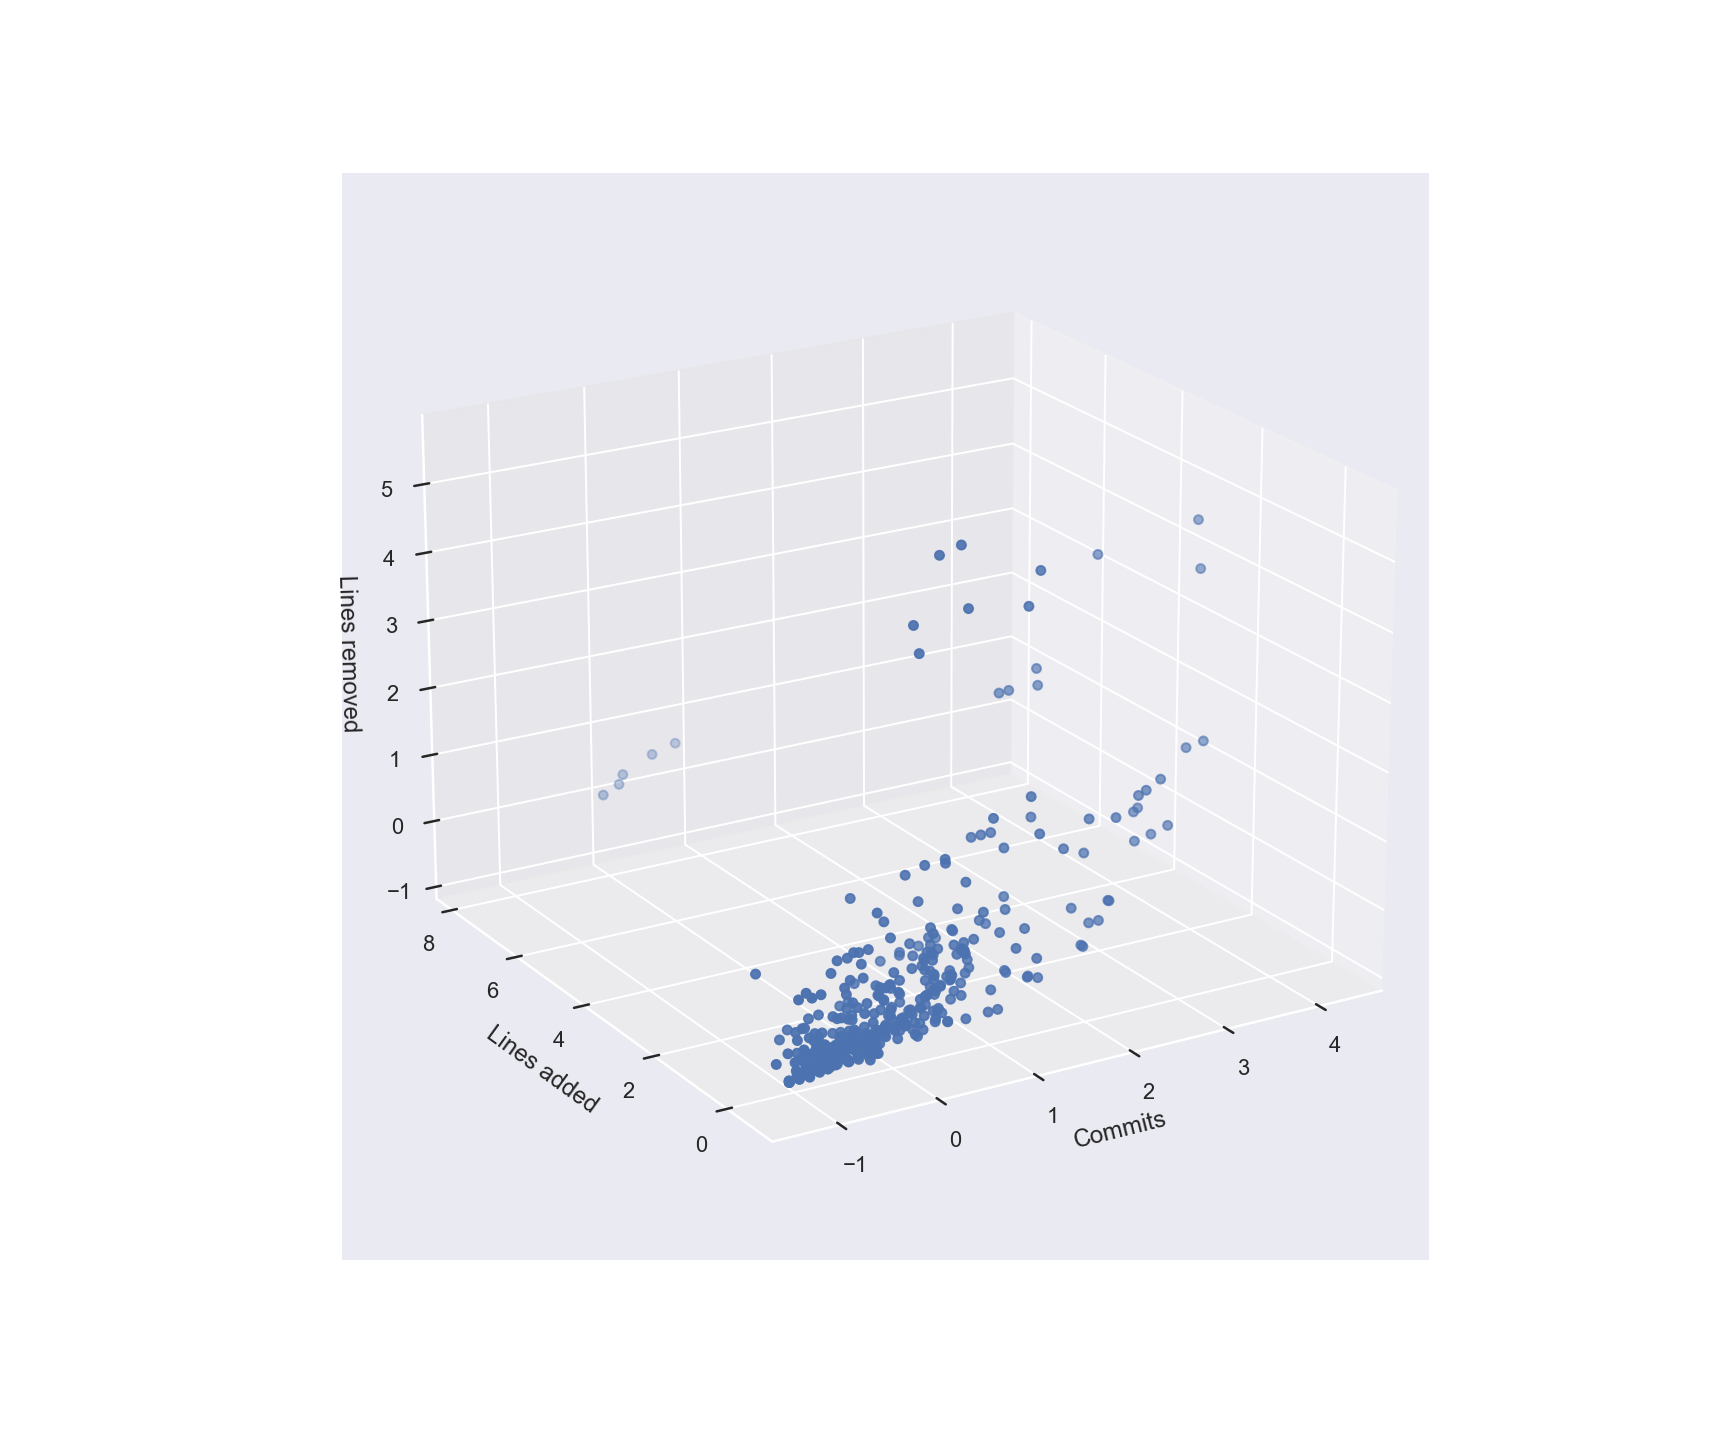

In [155]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(software_scaled.commits_7d, software_scaled.changes_7d_lines_added, software_scaled.changes_7d_lines_removed)
ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.show()

In [156]:
km = KMeans(n_clusters=2)
model = km.fit(software_scaled)

<IPython.core.display.Javascript object>


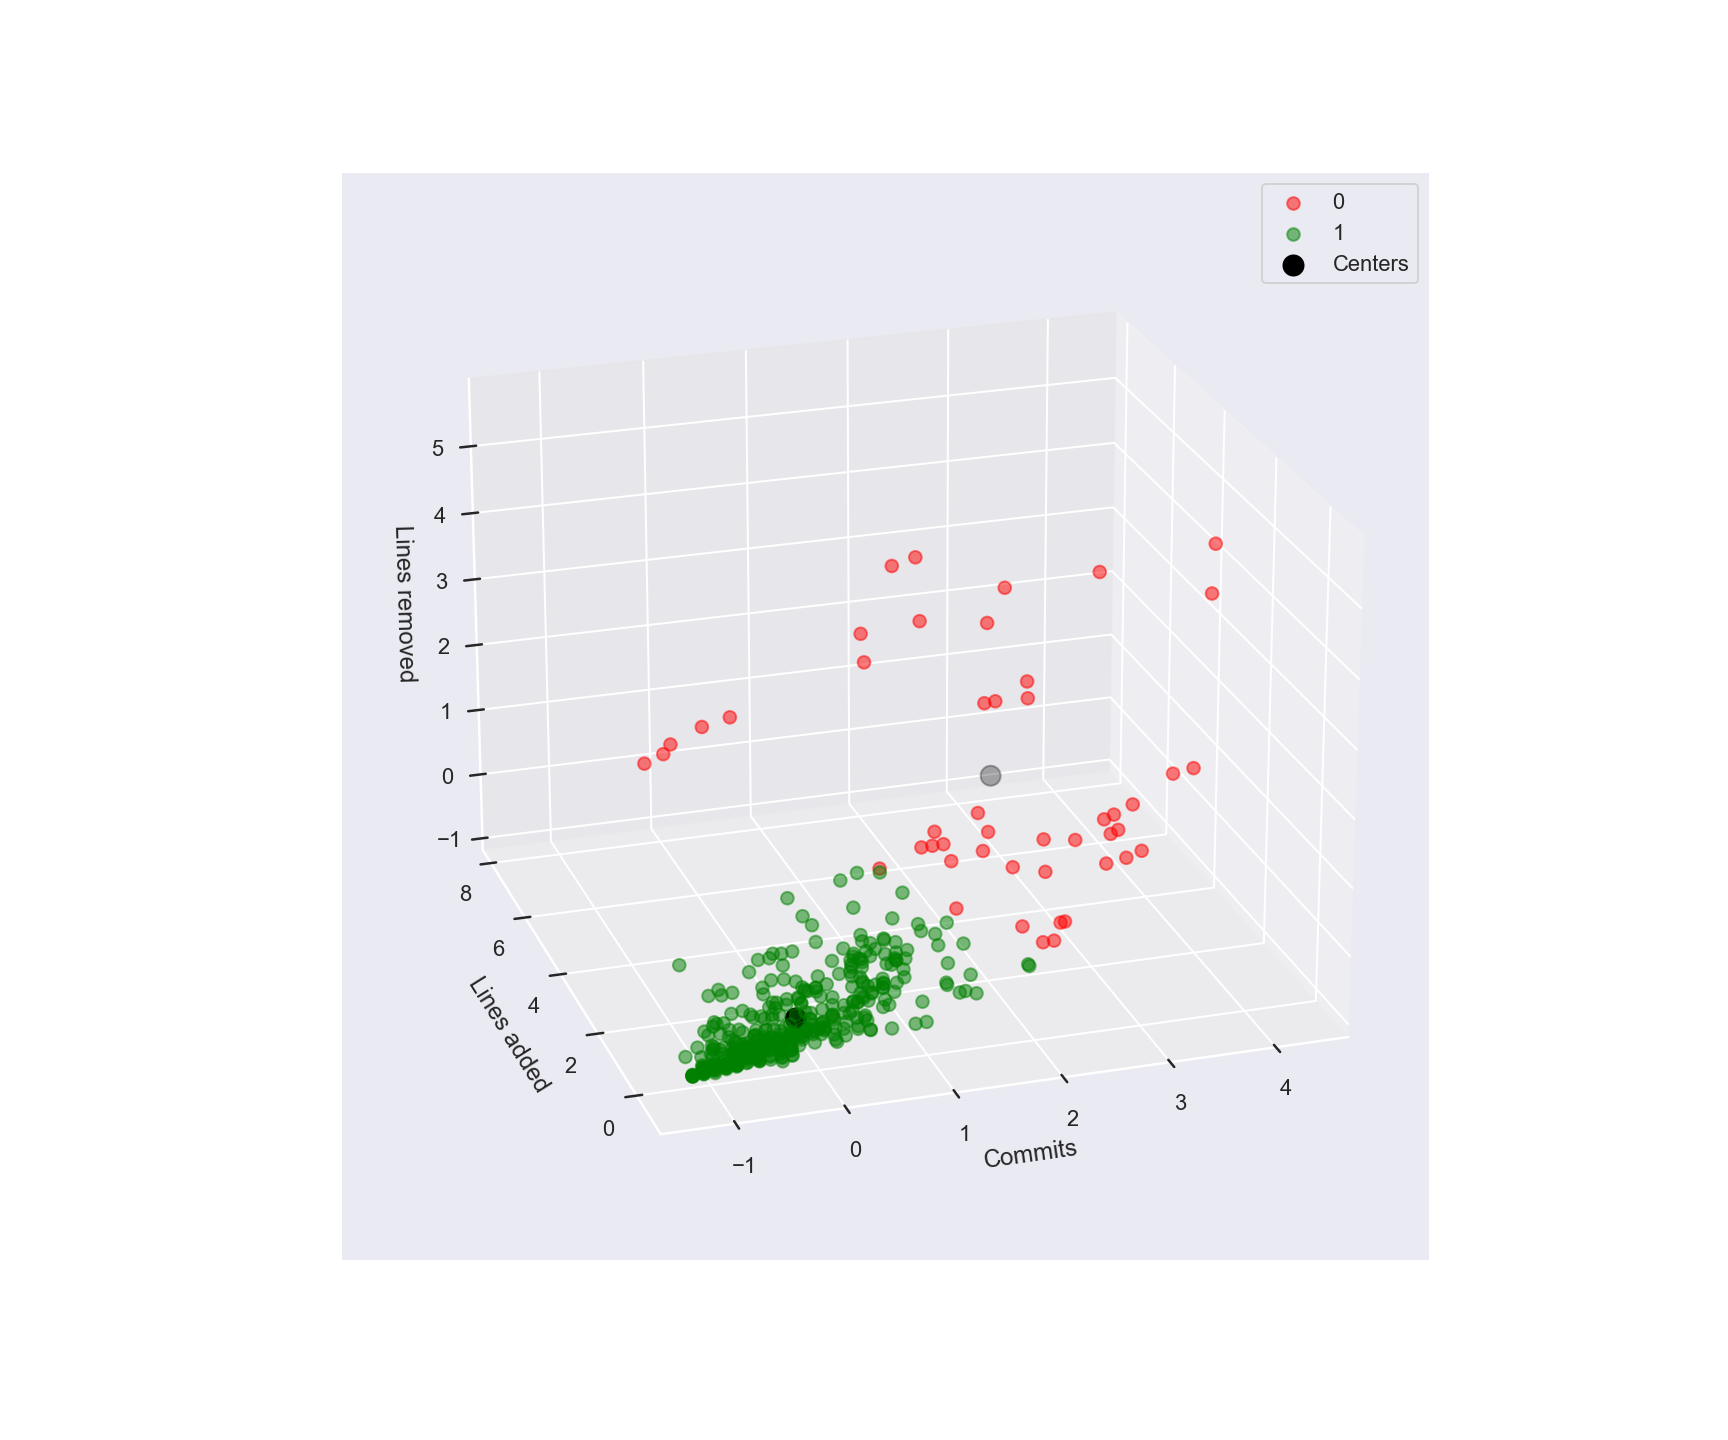

In [157]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','green','orange','yellow']
for i in range(np.max(model.labels_)+1):
    ax.scatter(software_scaled[model.labels_==i].commits_7d, software_scaled[model.labels_==i].changes_7d_lines_added, 
               software_scaled[model.labels_==i].changes_7d_lines_removed, label=i, c=colors[i], alpha=0.5, s=40)
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2],
           label='Centers', c="black", s=100)
ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()
    

In [158]:
def distance_from_center(commits, added, removed, label):
    '''
    Calculate the Euclidean distance between a data point and the center of its cluster.
    :return: The resulting Euclidean distance  
    '''
    center_commits =  model.cluster_centers_[label,0]
    center_lines_added =  model.cluster_centers_[label,1]
    center_lines_removed =  model.cluster_centers_[label,2]
    distance = np.sqrt((commits - center_commits) ** 2 + (added - center_lines_added) ** 2 
                       + (removed - center_lines_removed) ** 2)
    return np.round(distance, 3)
software_scaled['label'] = model.labels_
software_scaled['distance'] = distance_from_center(software_scaled.commits_7d, software_scaled.changes_7d_lines_added,
                                                 software_scaled.changes_7d_lines_removed,software_scaled.label)

In [159]:
anomalies_idx = list(software_scaled.sort_values('distance', ascending=False).head(13).index)
anomalies_kmeans = software_scaled[software_scaled.index.isin(anomalies_idx)]
print(anomalies_kmeans)

     commits_7d  changes_7d_lines_added  changes_7d_lines_removed  label  \
39     3.153535                2.527856                  4.428481      0   
40     4.284725                2.622502                  4.606665      0   
41     4.181889                2.312674                  4.012179      0   
80    -0.240034                7.455398                  0.304330      0   
81    -0.034363                7.561504                  0.369124      0   
82     0.376979                7.712174                  0.652599      0   
83     0.685485                7.876001                  0.680136      0   
84     0.068473                7.734244                  0.430679      0   
138    1.919510                1.027948                  4.969513      0   
139    1.096827                0.835684                  4.716816      0   
140    1.096827                1.023279                  5.544562      0   
141    0.891156                1.065721                  5.444131      0   
142    0.582

<IPython.core.display.Javascript object>


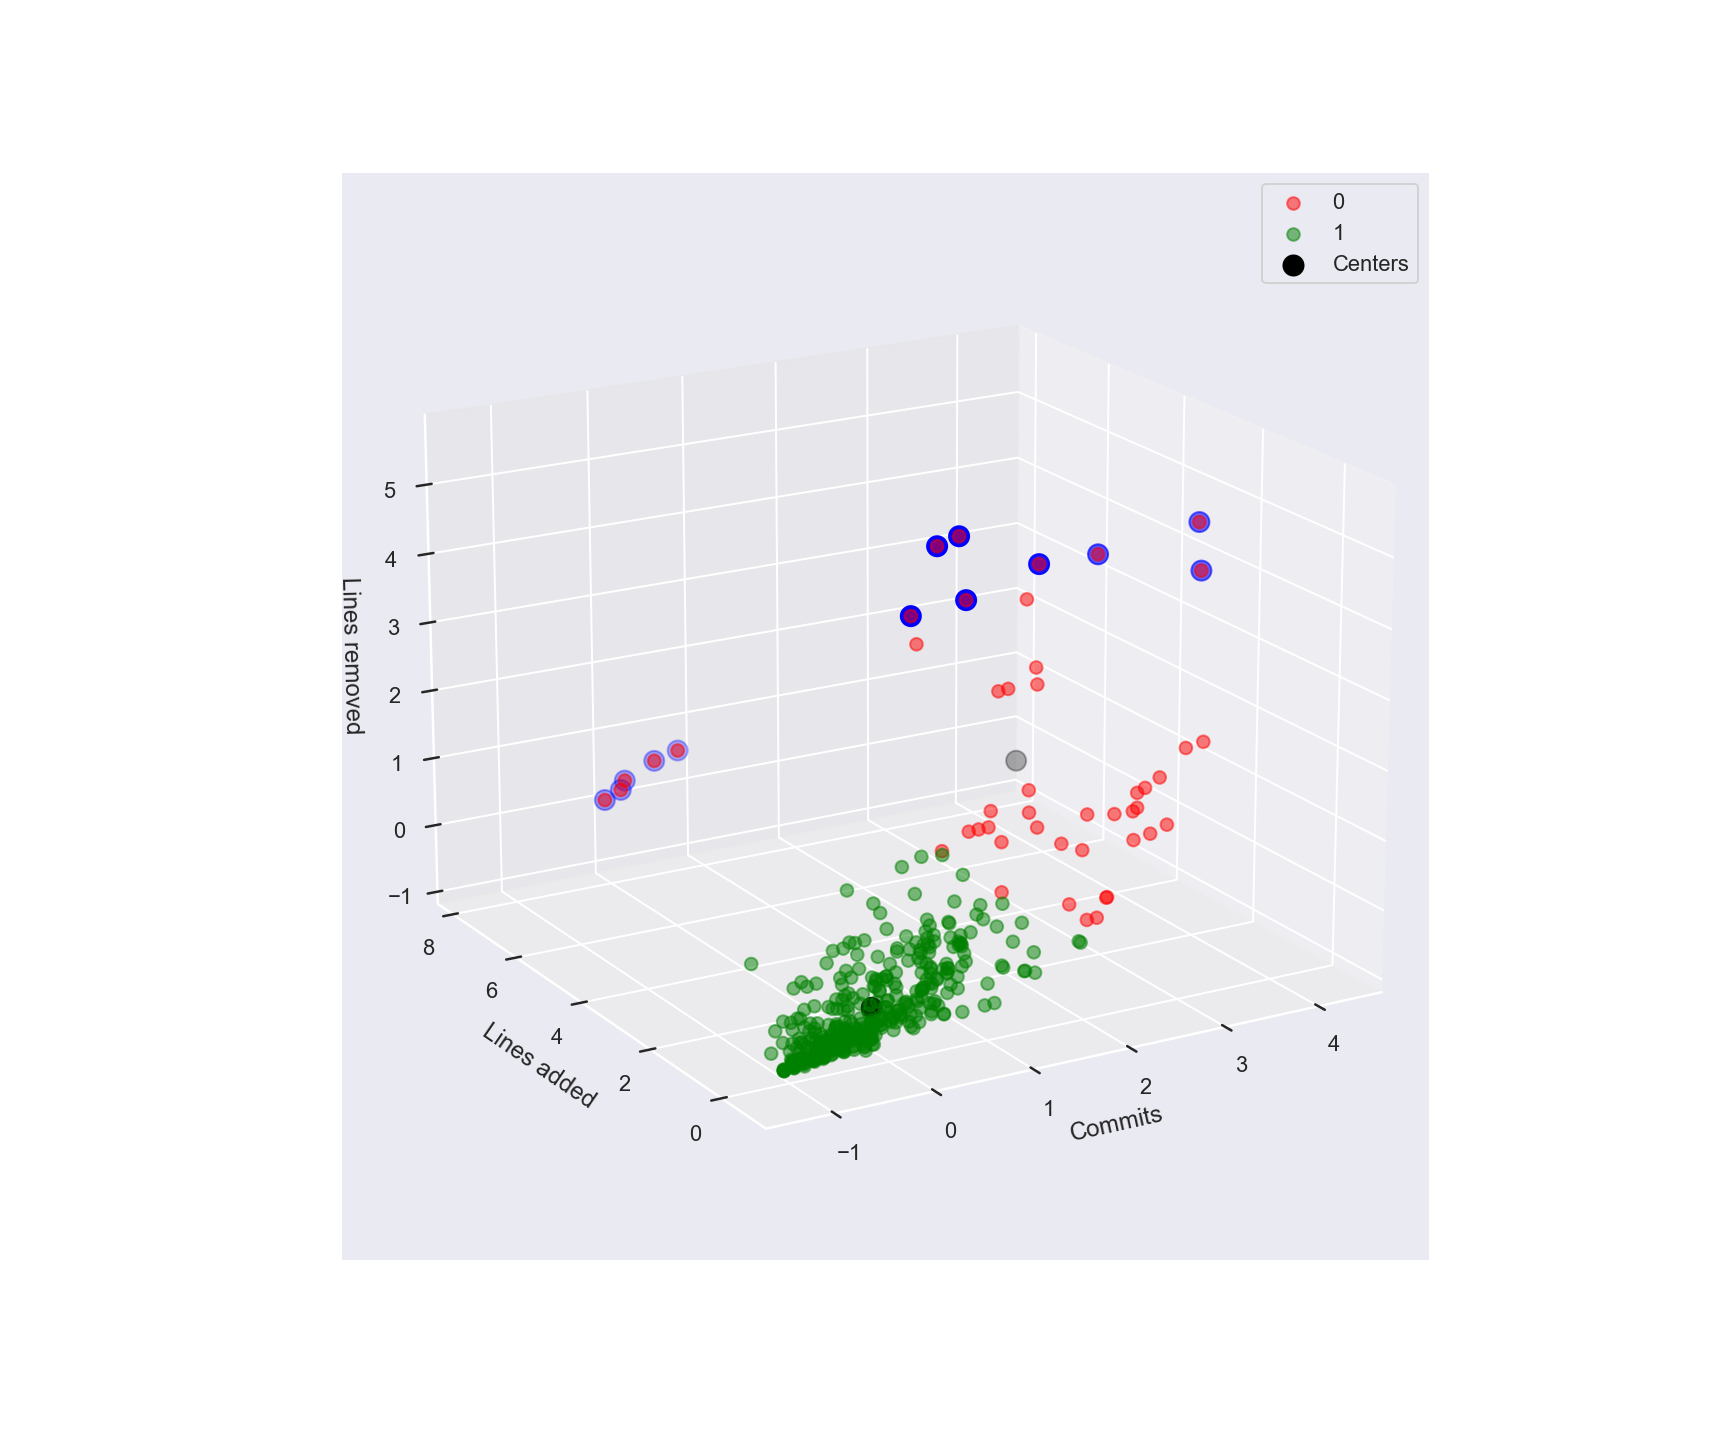

In [160]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','green','orange','yellow']
for i in range(np.max(model.labels_)+1):
    ax.scatter(software_scaled[model.labels_==i].commits_7d, software_scaled[model.labels_==i].changes_7d_lines_added, 
               software_scaled[model.labels_==i].changes_7d_lines_removed, label=i, c=colors[i], alpha=0.5, s=40)
ax.scatter(anomalies_kmeans.commits_7d, anomalies_kmeans.changes_7d_lines_added, anomalies_kmeans.changes_7d_lines_removed,
           c='blue', s=100)
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2],
           label='Centers', c="black", s=100) 
ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

### Combined Approach

#### Isolation Forest - Kmeans

By using Isolation Forest we can get the anomaly score for each data point. This score represents varies from -1 to 1 and is an indicator of how anomalous is the point. However these scores are also in a time series format and then we can perform a second step anomaly detection for (probably) obtaining better results. 


Here I am going to try to implement K-means after Isolation Forest.

#### Kmeans - Isolation Forest

Another way to look at it is that with Isolation Forest we get the nomaly scores (and the labels) of the data points **globaly**. This means that the avergae path length (that gives the anomaly score) is compared with data points from the whole time series and then the outliers are detected for the whole period.


However, there maybe are some points that even though they are not deviating that much from the whole dataset can be identified as **local** anomalies, meaning that they are outliers if they are compared with points in a more narrow and closer environment.

So, this is an attempt on first:
- Use **K-means** to split the data set into clusters.
- Use IF in each cluster separately to get the anomaly scores from more "similar" points.


In that way we are keeping the benefits from the two algorithms and also keep the "contamination" parameter that maybe useful for business cases.

<IPython.core.display.Javascript object>


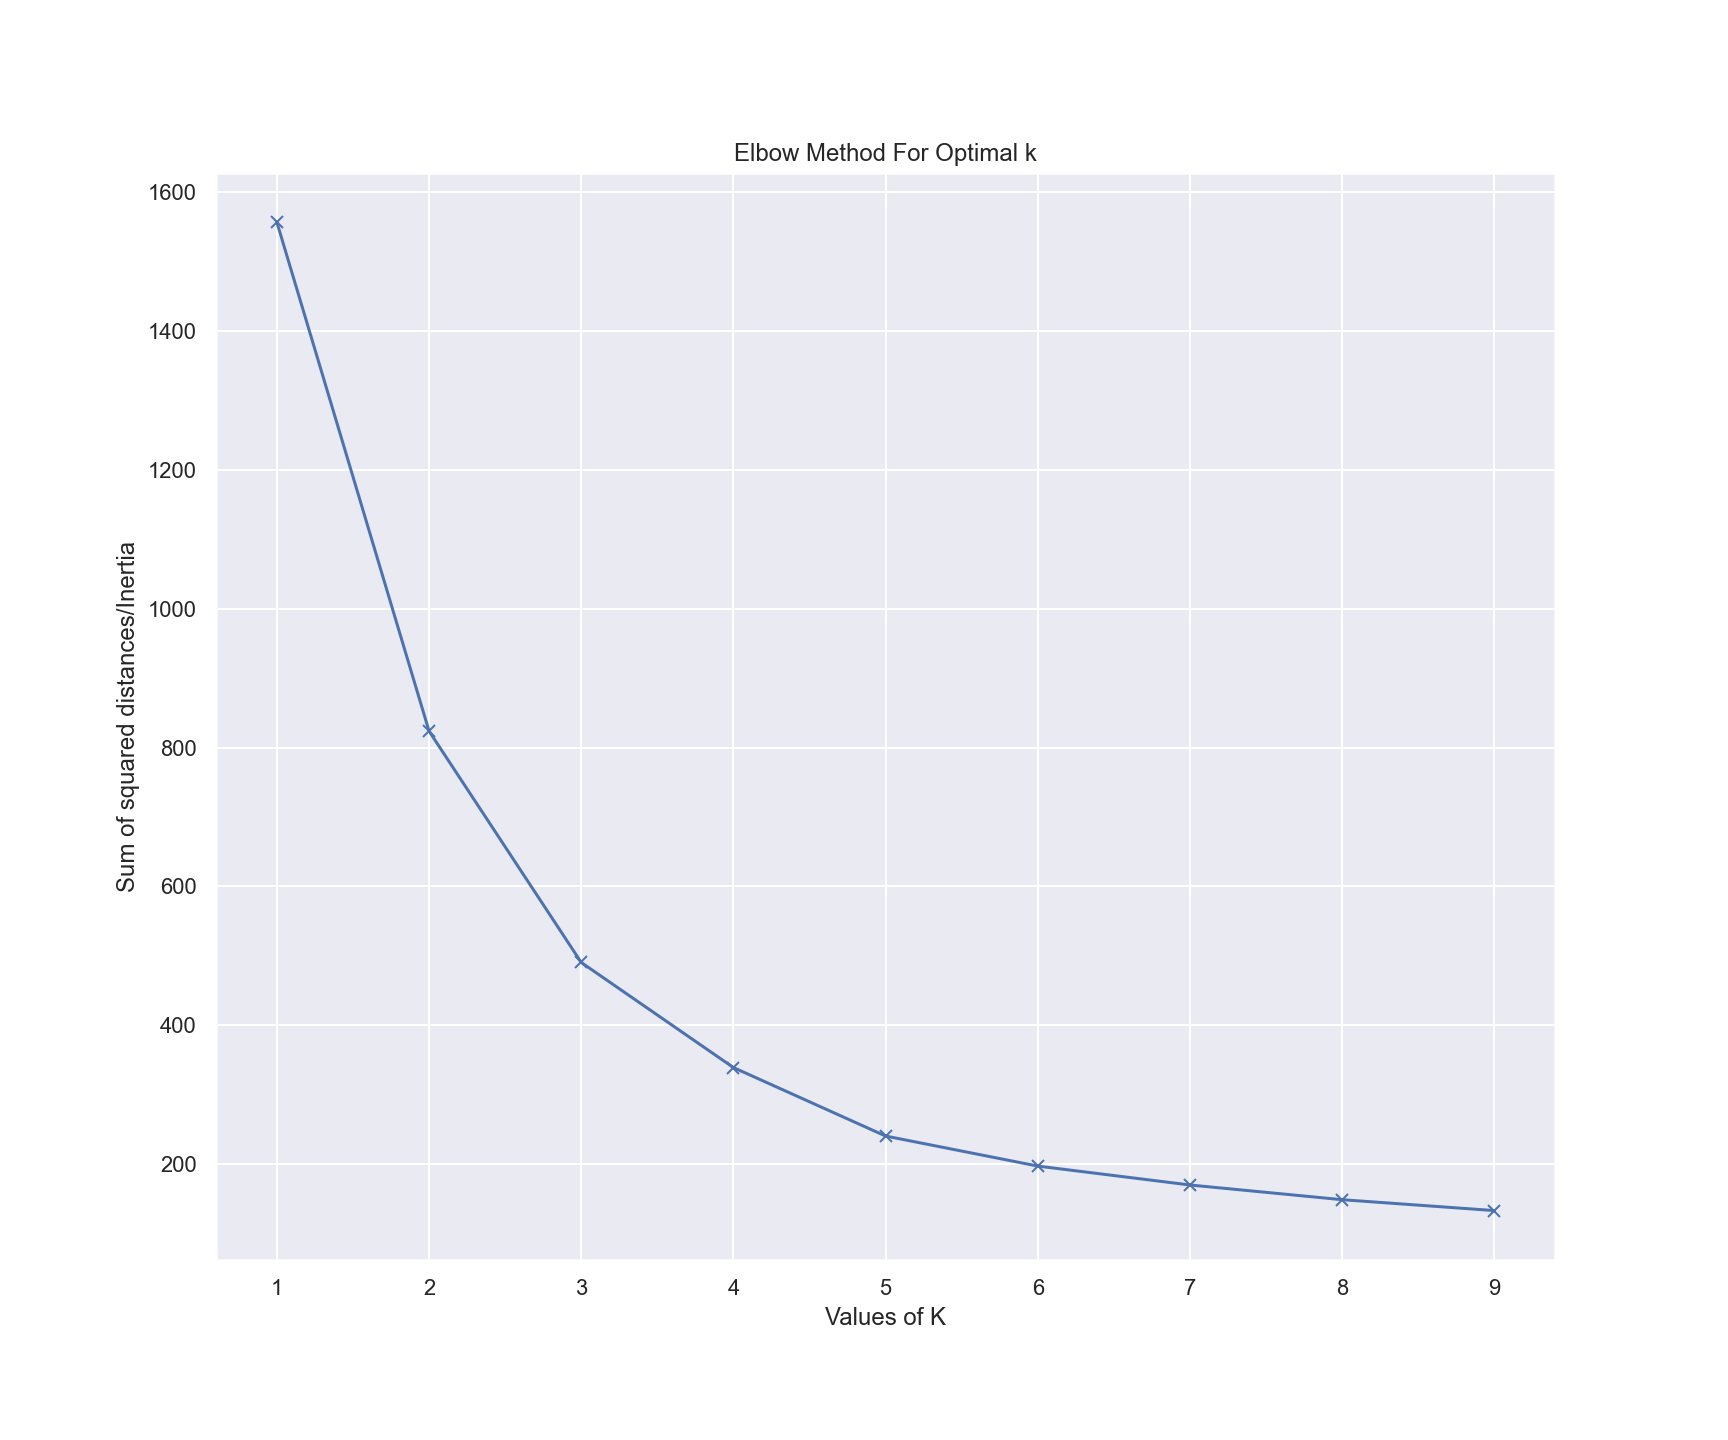

In [161]:
%matplotlib notebook
# Elbow method
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(software_scaled)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

In [162]:
from sklearn.metrics import silhouette_score

<IPython.core.display.Javascript object>


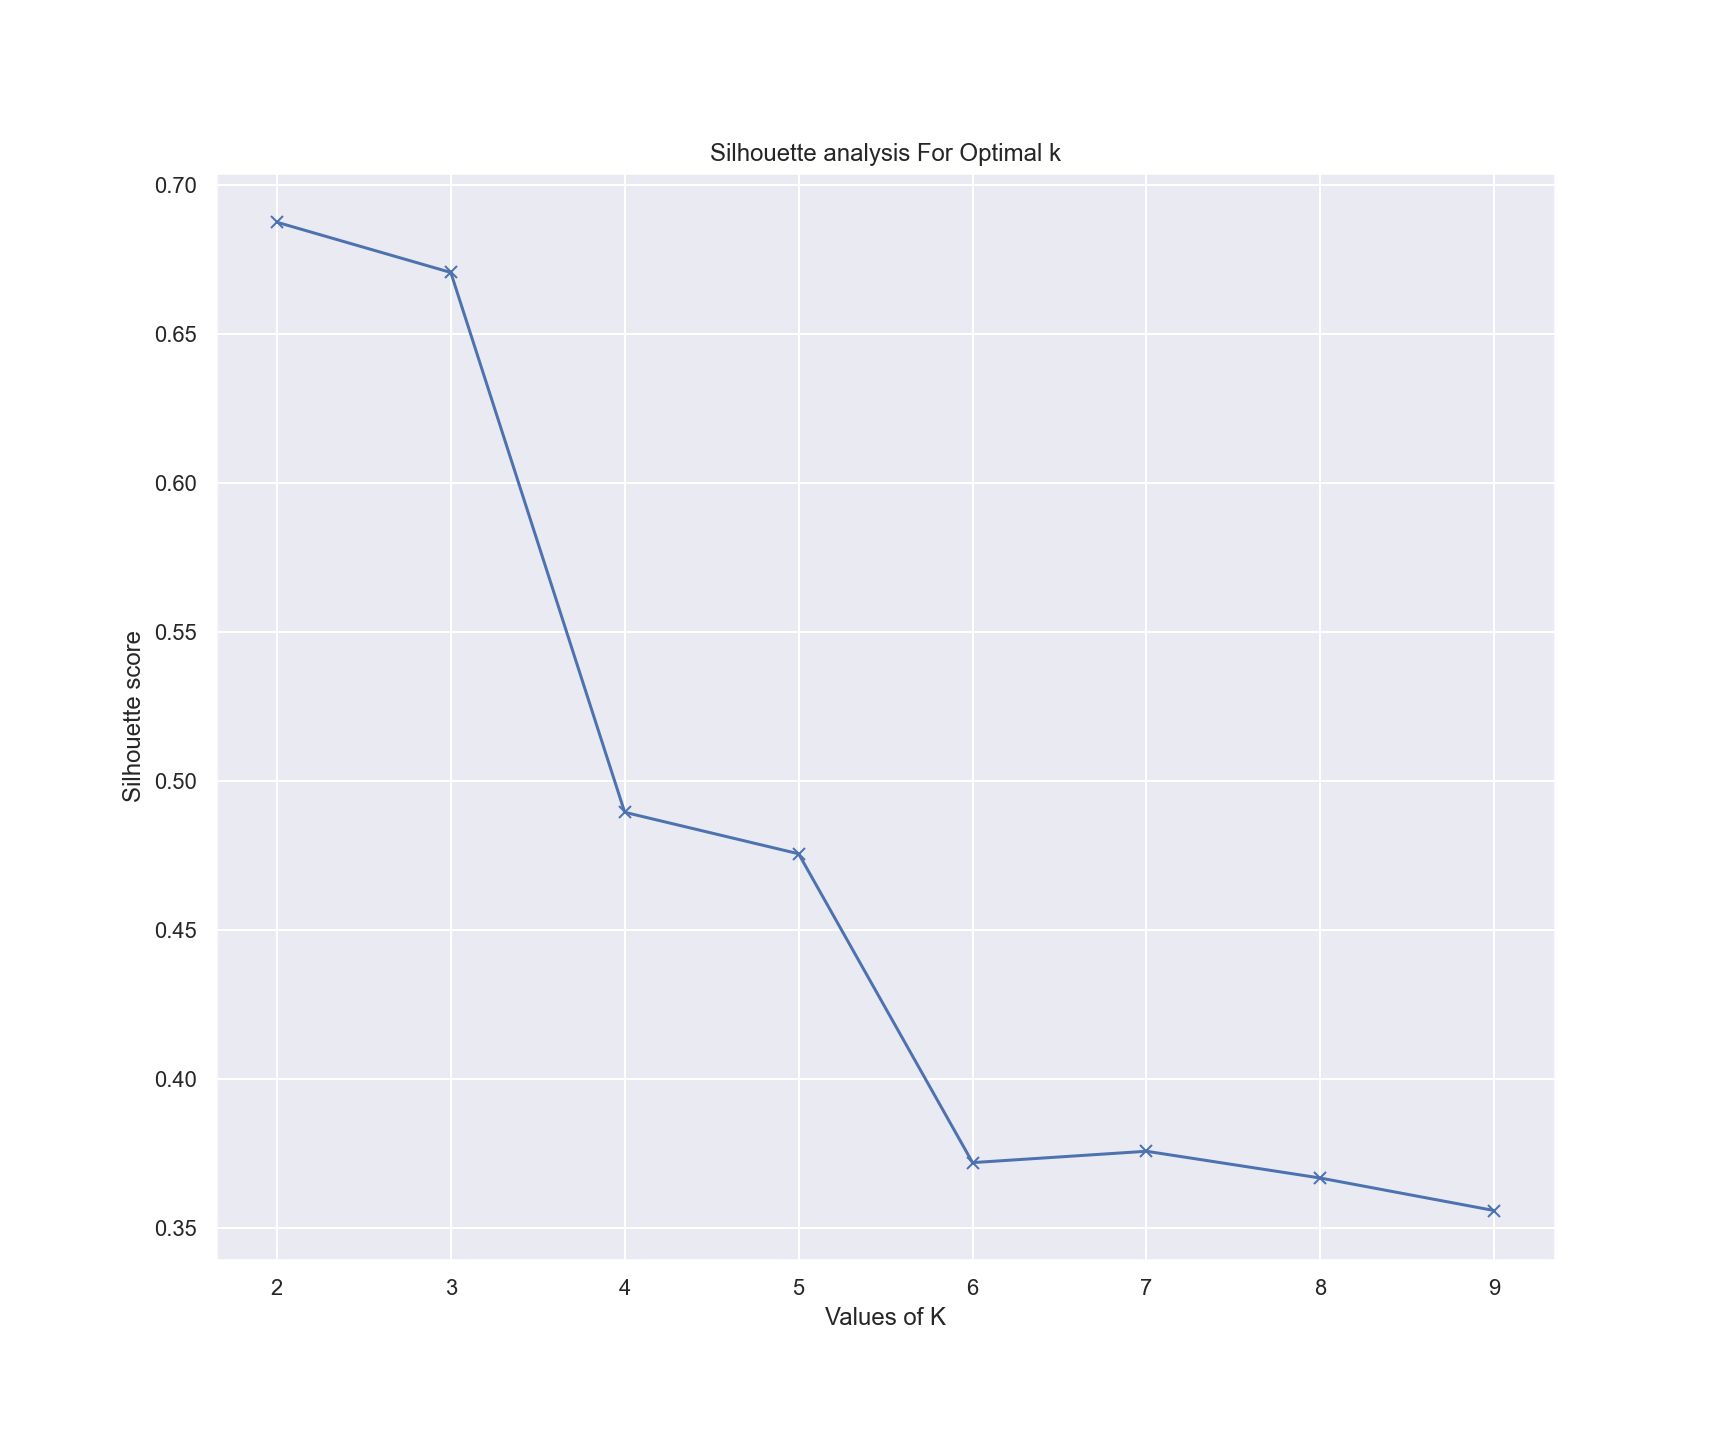

In [163]:
# Silhouette coefficient
range_n_clusters = range(2,10)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(software_scaled)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(software_scaled, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The two methods for finding the optimal value of K **do not agree**. We have two potential good choices for the number of clusters: 2 and 4.

In [164]:
# After having split the data into clusters we perform IF in each cluster with the hope to better identify the 
# local anomalies into the clusters.
software_scaled['cluster_anomaly_score'] = 0
software_scaled['cluster_anomaly_pred'] = 0
for i in range(np.max(model.labels_)+1):
    kmeans_isl_score, kmeans_isl_predictions = find_anomalies_isl(
    grouped_df_short[model.labels_ == i][['commits_7d','changes_7d_lines_added','changes_7d_lines_removed']],
    n_estimators = 100,max_samples = 300,contamination = 0.01,max_features = 3)
    
    software_scaled.loc[software_scaled['label'] == i, 'cluster_anomaly_score'] = kmeans_isl_score
    software_scaled.loc[software_scaled['label'] == i, 'cluster_anomaly_pred'] = kmeans_isl_predictions

<IPython.core.display.Javascript object>


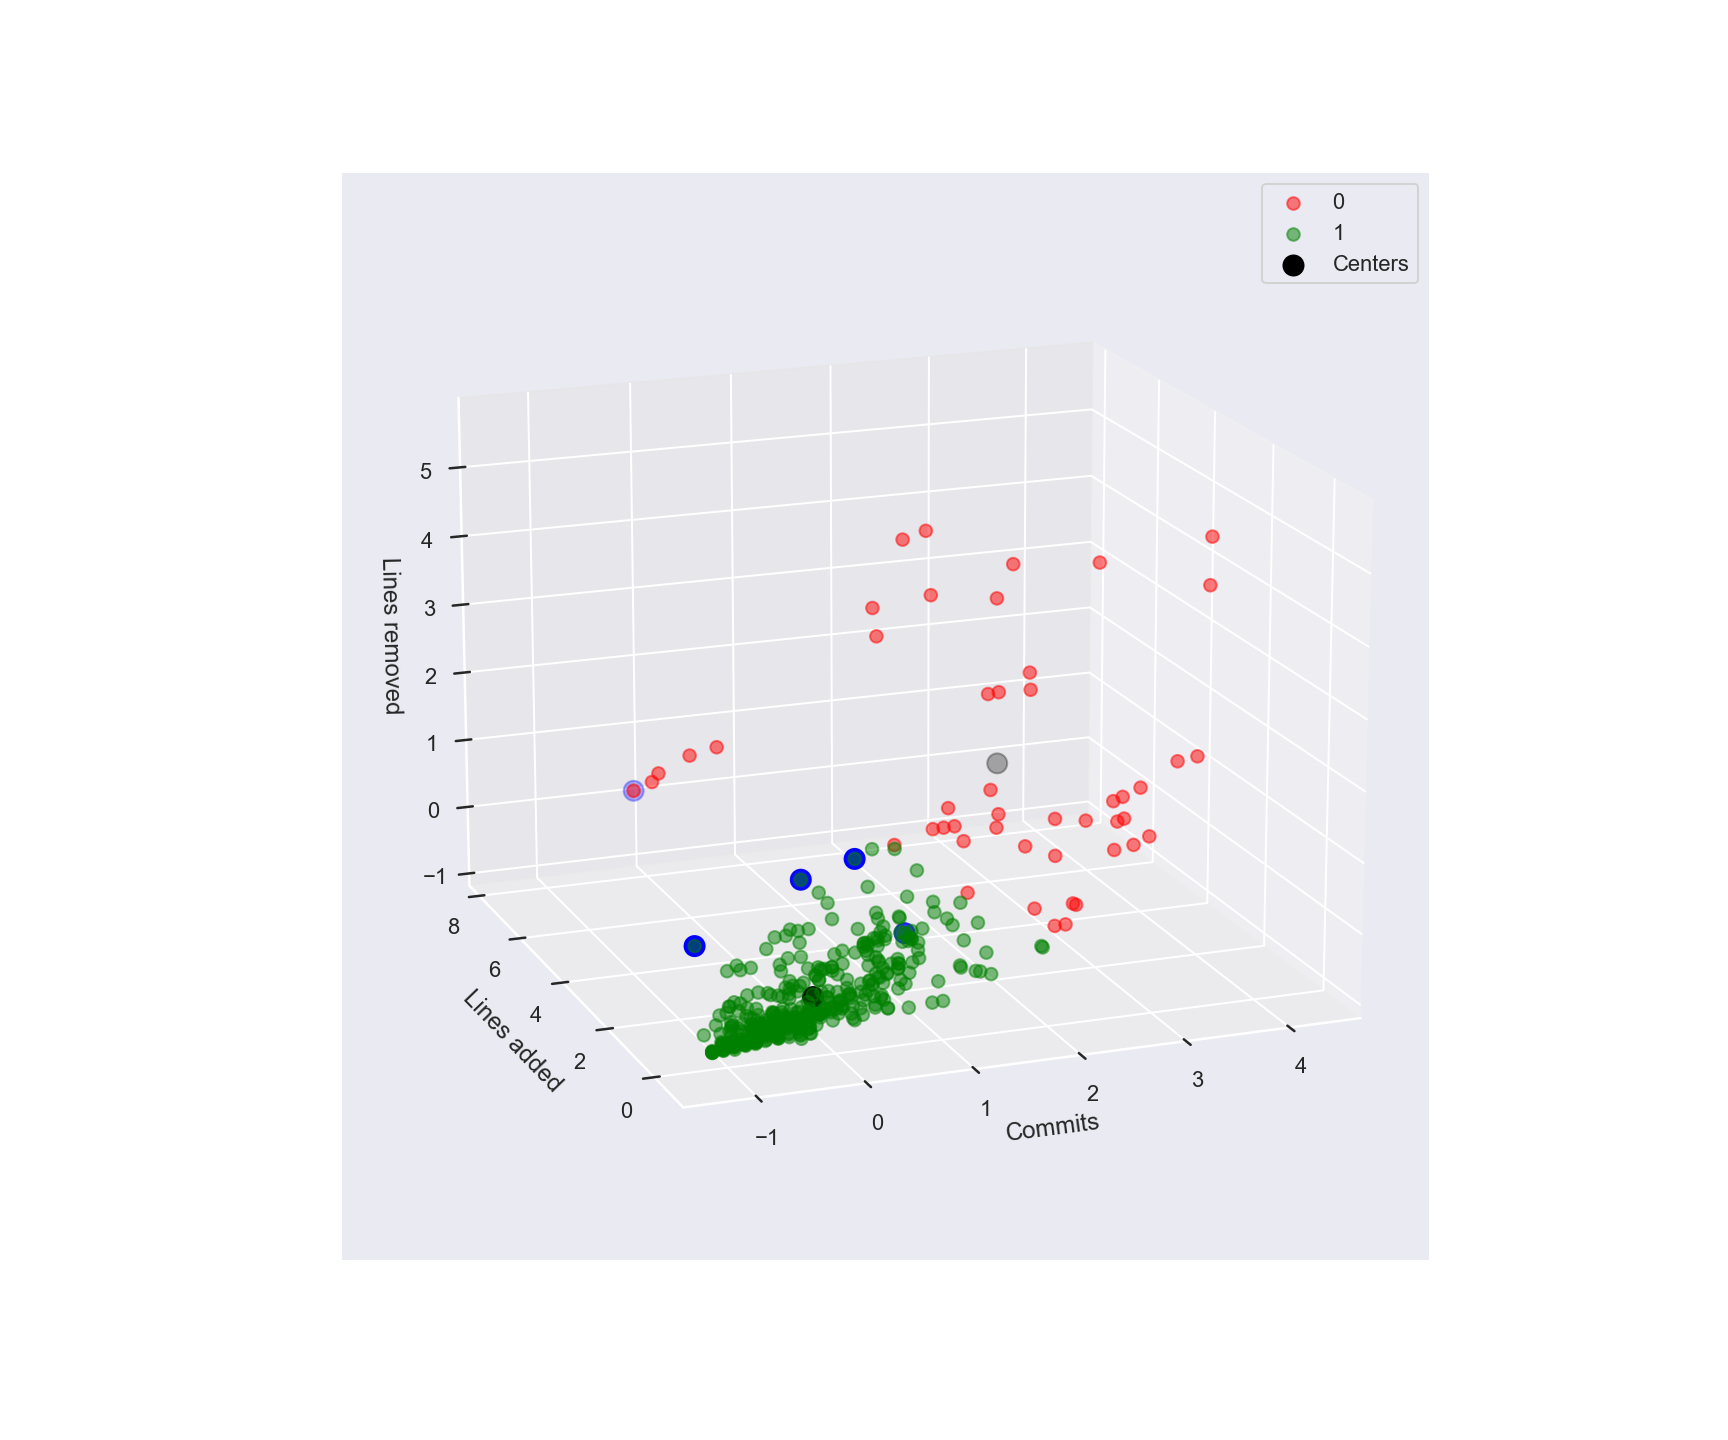

In [165]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
colors = ['red','green','orange','yellow']
for i in range(np.max(model.labels_)+1):
    ax.scatter(software_scaled[model.labels_==i].commits_7d, software_scaled[model.labels_==i].changes_7d_lines_added, 
               software_scaled[model.labels_==i].changes_7d_lines_removed, label=i, c=colors[i], alpha=0.5, s=40)
ax.scatter(software_scaled[software_scaled['cluster_anomaly_score'] < 0].commits_7d, 
           software_scaled[software_scaled['cluster_anomaly_score'] < 0].changes_7d_lines_added, 
           software_scaled[software_scaled['cluster_anomaly_score'] < 0].changes_7d_lines_removed,
           c='blue', s=100)
ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], model.cluster_centers_[:,2],
           label='Centers', c="black", s=100) 
ax.set_xlabel('Commits')
ax.set_ylabel('Lines added')
ax.set_zlabel('Lines removed')
plt.legend()

In [166]:
software_scaled['date'] = grouped_df_short.index
software_scaled = software_scaled.set_index('date')

<IPython.core.display.Javascript object>


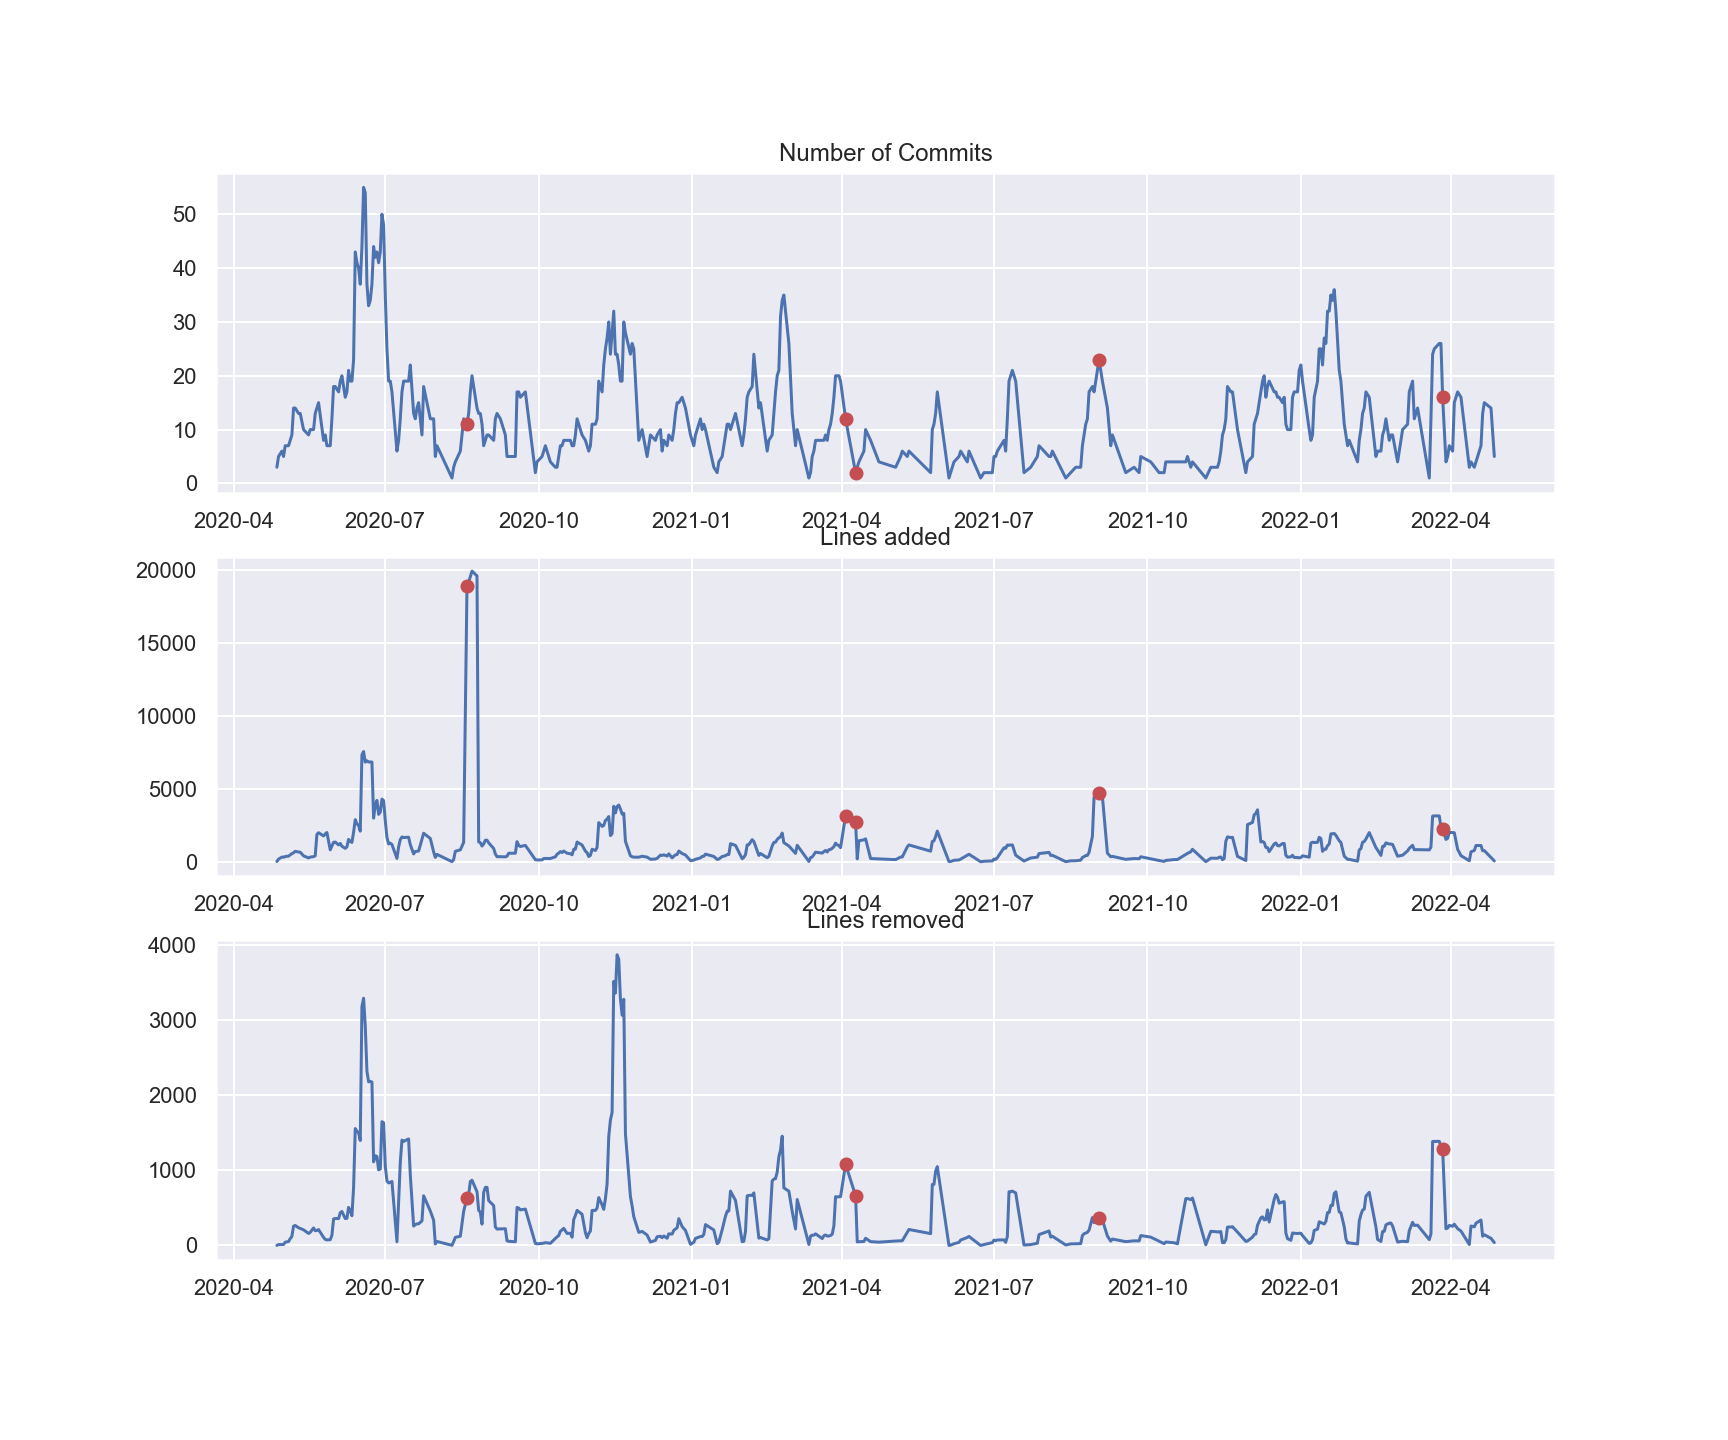

In [167]:
fig, ax = plt.subplots(3)
ax[0].set_title("Number of Commits")
ax[0].plot(grouped_df_short['commits_7d'])
ax[0].plot(grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].index, grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].commits_7d, 'ro')
ax[1].set_title("Lines added")
ax[1].plot(grouped_df_short['changes_7d_lines_added'])
ax[1].plot(grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].index, grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].changes_7d_lines_added, 'ro')
ax[2].set_title("Lines removed")
ax[2].plot(grouped_df_short['changes_7d_lines_removed'])
ax[2].plot(grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].index, grouped_df_short[software_scaled['cluster_anomaly_score'] < 0].changes_7d_lines_removed, 'ro')


This method **does not** give the expected results. Instead of better identifying the anomalies into the seperate clusters it identifies points as anomalies that do not seem to be and seem to miss other more apparent anomalies.


One explanation of this is that since the data are splitted into clusters, the clusters that contain more "outliying data" are not so easily separated by the Isolation trees. This is happening because now the outliers are not so distinct compared to the points in their own cluster, so we seem to miss some apparent anomalies.